In [1]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import gc

from kl_divergence import score as kaggle_score 
from engine_hms_trainer import (
    seed_everything, gen_non_overlap_samples, calc_entropy, evaluate_oof, get_logger, 
    Trainer, TARGETS, TARGETS_PRED, BRAIN_ACTIVITY
    )
from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig, CustomDataset, CustomEfficientNET, CustomVITMAE, DualEncoderModel, 
)

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from time import ctime, time
from sklearn.model_selection import KFold

import warnings
# warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

ALL_SPECS = np.load(PATHS.PRE_LOADED_SPECTROGRAMS, allow_pickle=True).item()
ALL_EEGS = np.load(PATHS.PRE_LOADED_EEGS, allow_pickle=True).item()

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


In [3]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=ModelConfig.SEED)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = CustomDataset(
        train_folds, TARGETS, ModelConfig, ALL_SPECS, ALL_EEGS, mode="train")

    valid_dataset = CustomDataset(
        valid_folds, TARGETS, ModelConfig, ALL_SPECS, ALL_EEGS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }
    train_loader = DataLoader(train_dataset, drop_last=True, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

def get_model(pretrained=True):
    backbone = ModelConfig.MODEL_BACKBONE

    if "efficientnet" in backbone:
        return CustomEfficientNET(ModelConfig, num_classes=6, pretrained=pretrained)
    elif "vit" in backbone:
        return CustomVITMAE(ModelConfig, num_classes=6, pretrained=pretrained)
    elif "dual" in backbone:
        return DualEncoderModel(ModelConfig, num_classes=6, pretrained=pretrained)
    else:
        return None

In [4]:
TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

In [5]:
# train_easy, train_hard, all_specs, all_eegs = load_kaggle_data(
#     paths.TRAIN_CSV, paths.PRE_LOADED_SPECTOGRAMS, paths.PRE_LOADED_EEGS, split_entropy=ModelConfig.SPLIT_ENTROPY)

train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:]

print("targets: ", targets.to_list())

train_csv['entropy'] = train_csv.apply(calc_entropy, axis=1, tgt_list=targets)
train_csv['total_votes'] = train_csv[targets].sum(axis=1)

hard_csv = train_csv[train_csv['entropy'] < ModelConfig.SPLIT_ENTROPY].copy().reset_index(drop=True)

train_all = gen_non_overlap_samples(train_csv, targets)
train_hard = gen_non_overlap_samples(hard_csv, targets)

print("train_all.shape = ", train_all.shape)
print("train_all nan_count: ", train_all.isnull().sum().sum())
display(train_all.head())

print(" ")

print("train_hard.shape = ", train_hard.shape)
print("train_hard nan_count: ", train_hard.isnull().sum().sum())
display(train_hard.head())

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all.shape =  (20183, 12)
train_all nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.0,0.000000,0.25,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.0,0.857143,0.00,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,642382,0.0,0.000000,0.00,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,5955,Other
3,751790,0.0,0.000000,1.00,0.000000,0.000000,0.000000,618728447,908.0,908.0,38549,GPD
4,778705,0.0,0.000000,0.00,0.000000,0.000000,1.000000,52296320,0.0,0.0,40955,Other


 
train_hard.shape =  (6187, 12)
train_hard nan_count:  0


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,20654,Other
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,20230,LPD
2,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,47999,Other
3,2482631,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other
4,2521897,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other


In [6]:
# # EfficientNet_B2_resplit (CV=0.5330731377333943)
# ModelConfig.EPOCHS = 6
# ModelConfig.BATCH_SIZE = 16
# ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
# ModelConfig.MODEL_BACKBONE = 'tf_efficientnet_b2'
# ModelConfig.MODEL_NAME = "EfficientNet_B2_resplit"
# ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
# ModelConfig.USE_EEG_SPECTROGRAMS = True
# ModelConfig.REGULARIZATION = None
# ModelConfig.AUGMENT = True
# ModelConfig.AUGMENTATIONS = ['xy_masking']

# config DualEncoder
ModelConfig.EPOCHS = 6
ModelConfig.BATCH_SIZE = 16
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.MODEL_BACKBONE = 'dual_encoder'
ModelConfig.MODEL_NAME = "DualEncoder_B0"
ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
ModelConfig.USE_EEG_SPECTROGRAMS = True
ModelConfig.REGULARIZATION = None
ModelConfig.AUGMENT = False
ModelConfig.AUGMENTATIONS = []
ModelConfig.DUAL_ENCODER_BACKBONE = 'tf_efficientnet_b0'

# # Config ViTMAE
# ModelConfig.EPOCHS = 6
# ModelConfig.MODEL_BACKBONE = 'vit_mae_base'
# ModelConfig.MODEL_NAME = "ViTMAE_base_mlp_dropout_020"
# ModelConfig.AUGMENT = True
# ModelConfig.USE_KAGGLE_SPECTROGRAMS = True
# ModelConfig.USE_EEG_SPECTROGRAMS = True
# ModelConfig.REGULARIZATION = None
# ModelConfig.AUGMENTATIONS = ['xy_masking']
# ModelConfig.MAE_PRETRAINED_WEIGHTS = "./outputs/vit_mae_pretraining/ViTMAE_PreTrained_Best.pth"
# ModelConfig.MAE_HIDDEN_DROPOUT_PROB = 0.1
# ModelConfig.MAE_ATTENTION_DROPOUT_PROB = 0.1
# ModelConfig.DROP_RATE = 0.2


In [7]:
logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)

oof_stage_1, oof_stage_2 = pd.DataFrame(), pd.DataFrame()
loss_history_1, loss_history_2 = [], []

for fold in range(k_folds):
    tik = time()
    model = get_model(pretrained=True)

    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    # STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid size {valid_folds.shape[0]} \n{'=' * 100}")
    logger.info(f"- First Stage -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

    # STAGE 2
    tik = time()
    logger.info(f"- Second Stage -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = get_model(pretrained=True)
    valid_predicts, loss_records = train_fold(
        model, fold, train_hard, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

****************************************************************************************************
Script Start: Sat Mar 23 18:00:44 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: DualEncoder_B0
MODEL_BACKBONE: dual_encoder
BATCH_SIZE: 16
EPOCHS: 6
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.15
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: False
AUGMENTATIONS: []
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
DUAL_ENCODER_BACKBONE: tf_efficientnet_b0
MAE_PRETRAINED_WEIGHTS: facebook/vit-mae-base
MAE_HIDDEN_DROPOUT_PROB: 0.05
MAE_ATTENTION_DROPOUT_PROB: 0.05
****************************************************************************************************
Fold: 0 || Valid size 3988 
- First Stage -


Train [0]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 1 [0/1012] | Train Loss: 1.5269 Grad: 241474.4844 LR: 4.0006e-06 | Elapse: 1.10s
Epoch 1 [50/1012] | Train Loss: 1.4466 Grad: 203728.8750 LR: 5.6668e-06 | Elapse: 7.47s
Epoch 1 [100/1012] | Train Loss: 1.4225 Grad: 112987.8828 LR: 1.0427e-05 | Elapse: 13.83s
Epoch 1 [150/1012] | Train Loss: 1.3855 Grad: 100398.3438 LR: 1.7962e-05 | Elapse: 20.21s
Epoch 1 [200/1012] | Train Loss: 1.3467 Grad: 117997.4531 LR: 2.7771e-05 | Elapse: 26.58s
Epoch 1 [250/1012] | Train Loss: 1.3100 Grad: 106078.2812 LR: 3.9197e-05 | Elapse: 32.96s
Epoch 1 [300/1012] | Train Loss: 1.2691 Grad: 100609.9375 LR: 5.1478e-05 | Elapse: 39.36s
Epoch 1 [350/1012] | Train Loss: 1.2337 Grad: 170535.4531 LR: 6.3793e-05 | Elapse: 45.75s
Epoch 1 [400/1012] | Train Loss: 1.1970 Grad: 131293.7656 LR: 7.5322e-05 | Elapse: 52.15s
Epoch 1 [450/1012] | Train Loss: 1.1580 Grad: 80844.4062 LR: 8.5293e-05 | Elapse: 58.56s
Epoch 1 [500/1012] | Train Loss: 1.1234 Grad: 106347.7734 LR: 9.3041e-05 | Elapse: 64.97s
Epoch 1 [550/101

Valid [0]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 1 [0/250] | Valid Loss: 0.4351 | Elapse: 0.11s
Epoch 1 [50/250] | Valid Loss: 0.6504 | Elapse: 3.92s
Epoch 1 [100/250] | Valid Loss: 0.6401 | Elapse: 7.75s
Epoch 1 [150/250] | Valid Loss: 0.6542 | Elapse: 11.58s
Epoch 1 [200/250] | Valid Loss: 0.6551 | Elapse: 15.40s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.9246; (valid) 0.6588 | Time: 149.84s
Best model found in epoch 1 | valid loss: 0.6588


Epoch 1 [249/250] | Valid Loss: 0.6588 | Elapse: 19.13s


Train [1]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 2 [0/1012] | Train Loss: 0.5908 Grad: 192384.7969 LR: 9.8639e-05 | Elapse: 0.14s
Epoch 2 [50/1012] | Train Loss: 0.6821 Grad: 108863.8672 LR: 9.8287e-05 | Elapse: 6.62s
Epoch 2 [100/1012] | Train Loss: 0.6533 Grad: 79211.2891 LR: 9.7894e-05 | Elapse: 13.08s
Epoch 2 [150/1012] | Train Loss: 0.6543 Grad: 137010.5156 LR: 9.7461e-05 | Elapse: 19.56s
Epoch 2 [200/1012] | Train Loss: 0.6508 Grad: 128135.1719 LR: 9.6990e-05 | Elapse: 26.05s
Epoch 2 [250/1012] | Train Loss: 0.6558 Grad: 88031.6797 LR: 9.6479e-05 | Elapse: 32.54s
Epoch 2 [300/1012] | Train Loss: 0.6488 Grad: 111980.4609 LR: 9.5931e-05 | Elapse: 39.02s
Epoch 2 [350/1012] | Train Loss: 0.6461 Grad: 94424.3359 LR: 9.5344e-05 | Elapse: 45.55s
Epoch 2 [400/1012] | Train Loss: 0.6436 Grad: 54542.1406 LR: 9.4720e-05 | Elapse: 52.05s
Epoch 2 [450/1012] | Train Loss: 0.6389 Grad: 34936.9805 LR: 9.4059e-05 | Elapse: 58.54s
Epoch 2 [500/1012] | Train Loss: 0.6311 Grad: 52182.7891 LR: 9.3361e-05 | Elapse: 65.03s
Epoch 2 [550/1012] | 

Valid [1]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 2 [0/250] | Valid Loss: 0.4646 | Elapse: 0.08s
Epoch 2 [50/250] | Valid Loss: 0.5687 | Elapse: 3.92s
Epoch 2 [100/250] | Valid Loss: 0.5439 | Elapse: 7.76s
Epoch 2 [150/250] | Valid Loss: 0.5568 | Elapse: 11.60s
Epoch 2 [200/250] | Valid Loss: 0.5549 | Elapse: 15.46s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.5820; (valid) 0.5634 | Time: 150.71s
Best model found in epoch 2 | valid loss: 0.5634


Epoch 2 [249/250] | Valid Loss: 0.5634 | Elapse: 19.19s


Train [2]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 3 [0/1012] | Train Loss: 0.3717 Grad: 201866.8906 LR: 8.4277e-05 | Elapse: 0.13s
Epoch 3 [50/1012] | Train Loss: 0.5163 Grad: 103259.0234 LR: 8.3216e-05 | Elapse: 6.63s
Epoch 3 [100/1012] | Train Loss: 0.4883 Grad: 66700.7188 LR: 8.2129e-05 | Elapse: 13.12s
Epoch 3 [150/1012] | Train Loss: 0.4943 Grad: 146065.4688 LR: 8.1015e-05 | Elapse: 19.61s
Epoch 3 [200/1012] | Train Loss: 0.4935 Grad: 117844.5547 LR: 7.9875e-05 | Elapse: 26.10s
Epoch 3 [250/1012] | Train Loss: 0.4992 Grad: 94047.8438 LR: 7.8711e-05 | Elapse: 32.60s
Epoch 3 [300/1012] | Train Loss: 0.4932 Grad: 106712.2500 LR: 7.7523e-05 | Elapse: 39.10s
Epoch 3 [350/1012] | Train Loss: 0.4949 Grad: 97626.4766 LR: 7.6312e-05 | Elapse: 45.61s
Epoch 3 [400/1012] | Train Loss: 0.4914 Grad: 63897.5977 LR: 7.5080e-05 | Elapse: 52.11s
Epoch 3 [450/1012] | Train Loss: 0.4874 Grad: 45258.3867 LR: 7.3826e-05 | Elapse: 58.61s
Epoch 3 [500/1012] | Train Loss: 0.4832 Grad: 53472.1992 LR: 7.2554e-05 | Elapse: 65.10s
Epoch 3 [550/1012] | 

Valid [2]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 3 [0/250] | Valid Loss: 0.4926 | Elapse: 0.09s
Epoch 3 [50/250] | Valid Loss: 0.5758 | Elapse: 3.94s
Epoch 3 [100/250] | Valid Loss: 0.5470 | Elapse: 7.77s
Epoch 3 [150/250] | Valid Loss: 0.5603 | Elapse: 11.61s
Epoch 3 [200/250] | Valid Loss: 0.5568 | Elapse: 15.44s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4464; (valid) 0.5691 | Time: 150.63s


Epoch 3 [249/250] | Valid Loss: 0.5691 | Elapse: 19.15s


Train [3]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 4 [0/1012] | Train Loss: 0.3268 Grad: 263183.5312 LR: 5.8642e-05 | Elapse: 0.13s
Epoch 4 [50/1012] | Train Loss: 0.3924 Grad: 64401.1016 LR: 5.7224e-05 | Elapse: 6.66s
Epoch 4 [100/1012] | Train Loss: 0.3689 Grad: 29090.4863 LR: 5.5799e-05 | Elapse: 13.14s
Epoch 4 [150/1012] | Train Loss: 0.3765 Grad: 91094.3984 LR: 5.4370e-05 | Elapse: 19.62s
Epoch 4 [200/1012] | Train Loss: 0.3750 Grad: 90345.4844 LR: 5.2938e-05 | Elapse: 26.10s
Epoch 4 [250/1012] | Train Loss: 0.3757 Grad: 43208.8477 LR: 5.1502e-05 | Elapse: 32.58s
Epoch 4 [300/1012] | Train Loss: 0.3726 Grad: 50919.8594 LR: 5.0066e-05 | Elapse: 39.05s
Epoch 4 [350/1012] | Train Loss: 0.3740 Grad: 89388.1250 LR: 4.8630e-05 | Elapse: 45.52s
Epoch 4 [400/1012] | Train Loss: 0.3707 Grad: 71116.9531 LR: 4.7194e-05 | Elapse: 52.03s
Epoch 4 [450/1012] | Train Loss: 0.3674 Grad: 61729.5039 LR: 4.5761e-05 | Elapse: 58.51s
Epoch 4 [500/1012] | Train Loss: 0.3655 Grad: 84174.6562 LR: 4.4332e-05 | Elapse: 65.00s
Epoch 4 [550/1012] | Trai

Valid [3]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 4 [0/250] | Valid Loss: 0.6356 | Elapse: 0.08s
Epoch 4 [50/250] | Valid Loss: 0.5957 | Elapse: 3.93s
Epoch 4 [100/250] | Valid Loss: 0.5600 | Elapse: 7.78s
Epoch 4 [150/250] | Valid Loss: 0.5767 | Elapse: 11.62s
Epoch 4 [200/250] | Valid Loss: 0.5715 | Elapse: 15.47s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3379; (valid) 0.5833 | Time: 150.44s


Epoch 4 [249/250] | Valid Loss: 0.5833 | Elapse: 19.19s


Train [4]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 5 [0/1012] | Train Loss: 0.2850 Grad: 215969.5312 LR: 3.0171e-05 | Elapse: 0.13s
Epoch 5 [50/1012] | Train Loss: 0.3054 Grad: 63792.7617 LR: 2.8861e-05 | Elapse: 6.59s
Epoch 5 [100/1012] | Train Loss: 0.2831 Grad: 37851.4219 LR: 2.7568e-05 | Elapse: 13.05s
Epoch 5 [150/1012] | Train Loss: 0.2945 Grad: 58996.7969 LR: 2.6294e-05 | Elapse: 19.54s
Epoch 5 [200/1012] | Train Loss: 0.2955 Grad: 71823.6562 LR: 2.5040e-05 | Elapse: 26.03s
Epoch 5 [250/1012] | Train Loss: 0.2974 Grad: 45505.1406 LR: 2.3806e-05 | Elapse: 32.50s
Epoch 5 [300/1012] | Train Loss: 0.2933 Grad: 50690.7734 LR: 2.2594e-05 | Elapse: 38.98s
Epoch 5 [350/1012] | Train Loss: 0.2937 Grad: 87154.3594 LR: 2.1404e-05 | Elapse: 45.45s
Epoch 5 [400/1012] | Train Loss: 0.2912 Grad: 66548.8125 LR: 2.0239e-05 | Elapse: 51.92s
Epoch 5 [450/1012] | Train Loss: 0.2898 Grad: 45093.2930 LR: 1.9097e-05 | Elapse: 58.43s
Epoch 5 [500/1012] | Train Loss: 0.2874 Grad: 70329.7656 LR: 1.7982e-05 | Elapse: 64.90s
Epoch 5 [550/1012] | Trai

Valid [4]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 5 [0/250] | Valid Loss: 0.5541 | Elapse: 0.08s
Epoch 5 [50/250] | Valid Loss: 0.6018 | Elapse: 3.93s
Epoch 5 [100/250] | Valid Loss: 0.5693 | Elapse: 7.78s
Epoch 5 [150/250] | Valid Loss: 0.5834 | Elapse: 11.64s
Epoch 5 [200/250] | Valid Loss: 0.5762 | Elapse: 15.48s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2727; (valid) 0.5876 | Time: 150.42s


Epoch 5 [249/250] | Valid Loss: 0.5876 | Elapse: 19.20s


Train [5]:   0%|          | 0/1012 [00:00<?, ?batch/s]

Epoch 6 [0/1012] | Train Loss: 0.2473 Grad: 192066.3281 LR: 8.2308e-06 | Elapse: 0.14s
Epoch 6 [50/1012] | Train Loss: 0.2711 Grad: 48358.2734 LR: 7.4601e-06 | Elapse: 6.63s
Epoch 6 [100/1012] | Train Loss: 0.2507 Grad: 28087.6895 LR: 6.7246e-06 | Elapse: 13.15s
Epoch 6 [150/1012] | Train Loss: 0.2598 Grad: 74936.1875 LR: 6.0248e-06 | Elapse: 19.66s
Epoch 6 [200/1012] | Train Loss: 0.2609 Grad: 83430.1641 LR: 5.3614e-06 | Elapse: 26.21s
Epoch 6 [250/1012] | Train Loss: 0.2642 Grad: 46141.0508 LR: 4.7349e-06 | Elapse: 32.72s
Epoch 6 [300/1012] | Train Loss: 0.2608 Grad: 40309.1328 LR: 4.1458e-06 | Elapse: 39.22s
Epoch 6 [350/1012] | Train Loss: 0.2614 Grad: 87430.3594 LR: 3.5946e-06 | Elapse: 45.71s
Epoch 6 [400/1012] | Train Loss: 0.2612 Grad: 78191.1172 LR: 3.0817e-06 | Elapse: 52.18s
Epoch 6 [450/1012] | Train Loss: 0.2606 Grad: 36579.9688 LR: 2.6077e-06 | Elapse: 58.67s
Epoch 6 [500/1012] | Train Loss: 0.2599 Grad: 65679.5938 LR: 2.1728e-06 | Elapse: 65.18s
Epoch 6 [550/1012] | Trai

Valid [5]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 6 [0/250] | Valid Loss: 0.5954 | Elapse: 0.09s
Epoch 6 [50/250] | Valid Loss: 0.6075 | Elapse: 3.93s
Epoch 6 [100/250] | Valid Loss: 0.5767 | Elapse: 7.78s
Epoch 6 [150/250] | Valid Loss: 0.5907 | Elapse: 11.62s
Epoch 6 [200/250] | Valid Loss: 0.5842 | Elapse: 15.46s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2511; (valid) 0.5961 | Time: 150.65s


Epoch 6 [249/250] | Valid Loss: 0.5961 | Elapse: 19.18s


Fold 0 Valid Loss: 0.5633618235588074
Elapse: 15.07 min 
- Second Stage -
Use Checkpoint: DualEncoder_B0_fold_0_stage_1.pth


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/386] | Train Loss: 0.4304 Grad: nan LR: 4.0045e-06 | Elapse: 0.13s
Epoch 1 [50/386] | Train Loss: 0.4491 Grad: 86177.8203 LR: 1.5127e-05 | Elapse: 6.63s
Epoch 1 [100/386] | Train Loss: 0.4339 Grad: 63918.6680 LR: 4.2708e-05 | Elapse: 13.13s
Epoch 1 [150/386] | Train Loss: 0.4152 Grad: 52564.1133 LR: 7.4436e-05 | Elapse: 19.61s
Epoch 1 [200/386] | Train Loss: 0.3995 Grad: 62075.3594 LR: 9.6150e-05 | Elapse: 26.10s
Epoch 1 [250/386] | Train Loss: 0.3909 Grad: 46776.7266 LR: 9.9976e-05 | Elapse: 32.60s
Epoch 1 [300/386] | Train Loss: 0.3838 Grad: 39989.8945 LR: 9.9719e-05 | Elapse: 39.10s
Epoch 1 [350/386] | Train Loss: 0.3741 Grad: 35438.6094 LR: 9.9179e-05 | Elapse: 45.61s
Epoch 1 [385/386] | Train Loss: 0.3706 Grad: 44290.9102 LR: 9.8635e-05 | Elapse: 50.16s


Valid [0]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 1 [0/250] | Valid Loss: 0.7094 | Elapse: 0.08s
Epoch 1 [50/250] | Valid Loss: 0.6041 | Elapse: 3.94s
Epoch 1 [100/250] | Valid Loss: 0.5719 | Elapse: 7.80s
Epoch 1 [150/250] | Valid Loss: 0.5728 | Elapse: 11.66s
Epoch 1 [200/250] | Valid Loss: 0.5693 | Elapse: 15.52s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3706; (valid) 0.5721 | Time: 69.40s
Best model found in epoch 1 | valid loss: 0.5721


Epoch 1 [249/250] | Valid Loss: 0.5721 | Elapse: 19.23s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.3334 Grad: 241537.9062 LR: 9.8618e-05 | Elapse: 0.13s
Epoch 2 [50/386] | Train Loss: 0.3137 Grad: 72060.1484 LR: 9.7601e-05 | Elapse: 6.61s
Epoch 2 [100/386] | Train Loss: 0.3121 Grad: 67776.5000 LR: 9.6314e-05 | Elapse: 13.09s
Epoch 2 [150/386] | Train Loss: 0.3060 Grad: 74883.8750 LR: 9.4765e-05 | Elapse: 19.57s
Epoch 2 [200/386] | Train Loss: 0.2966 Grad: 70584.2422 LR: 9.2961e-05 | Elapse: 26.06s
Epoch 2 [250/386] | Train Loss: 0.2911 Grad: 87067.6406 LR: 9.0914e-05 | Elapse: 32.57s
Epoch 2 [300/386] | Train Loss: 0.2872 Grad: 65460.9609 LR: 8.8634e-05 | Elapse: 39.06s
Epoch 2 [350/386] | Train Loss: 0.2808 Grad: 51499.0781 LR: 8.6135e-05 | Elapse: 45.56s
Epoch 2 [385/386] | Train Loss: 0.2785 Grad: 89867.1719 LR: 8.4264e-05 | Elapse: 50.10s


Valid [1]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 2 [0/250] | Valid Loss: 0.6319 | Elapse: 0.08s
Epoch 2 [50/250] | Valid Loss: 0.5751 | Elapse: 3.93s
Epoch 2 [100/250] | Valid Loss: 0.5435 | Elapse: 7.78s
Epoch 2 [150/250] | Valid Loss: 0.5447 | Elapse: 11.62s
Epoch 2 [200/250] | Valid Loss: 0.5464 | Elapse: 15.46s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.2785; (valid) 0.5512 | Time: 69.28s
Best model found in epoch 2 | valid loss: 0.5512


Epoch 2 [249/250] | Valid Loss: 0.5512 | Elapse: 19.17s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.2496 Grad: 194992.6562 LR: 8.4209e-05 | Elapse: 0.13s
Epoch 3 [50/386] | Train Loss: 0.2436 Grad: 62185.6367 LR: 8.1367e-05 | Elapse: 6.63s
Epoch 3 [100/386] | Train Loss: 0.2416 Grad: 68445.6641 LR: 7.8347e-05 | Elapse: 13.13s
Epoch 3 [150/386] | Train Loss: 0.2375 Grad: 67835.0000 LR: 7.5166e-05 | Elapse: 19.62s
Epoch 3 [200/386] | Train Loss: 0.2326 Grad: 64167.9180 LR: 7.1843e-05 | Elapse: 26.12s
Epoch 3 [250/386] | Train Loss: 0.2298 Grad: 79599.5391 LR: 6.8396e-05 | Elapse: 32.62s
Epoch 3 [300/386] | Train Loss: 0.2273 Grad: 83151.3438 LR: 6.4844e-05 | Elapse: 39.14s
Epoch 3 [350/386] | Train Loss: 0.2232 Grad: 46052.5820 LR: 6.1209e-05 | Elapse: 45.66s
Epoch 3 [385/386] | Train Loss: 0.2209 Grad: 60501.2969 LR: 5.8625e-05 | Elapse: 50.22s


Valid [2]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 3 [0/250] | Valid Loss: 0.5797 | Elapse: 0.09s
Epoch 3 [50/250] | Valid Loss: 0.5466 | Elapse: 3.94s
Epoch 3 [100/250] | Valid Loss: 0.5185 | Elapse: 7.80s
Epoch 3 [150/250] | Valid Loss: 0.5181 | Elapse: 11.65s
Epoch 3 [200/250] | Valid Loss: 0.5221 | Elapse: 15.50s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.2209; (valid) 0.5261 | Time: 69.43s
Best model found in epoch 3 | valid loss: 0.5261


Epoch 3 [249/250] | Valid Loss: 0.5261 | Elapse: 19.21s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.2124 Grad: 145899.2344 LR: 5.8551e-05 | Elapse: 0.13s
Epoch 4 [50/386] | Train Loss: 0.2007 Grad: 144180.9844 LR: 5.4819e-05 | Elapse: 6.61s
Epoch 4 [100/386] | Train Loss: 0.1995 Grad: 140559.2344 LR: 5.1059e-05 | Elapse: 13.09s
Epoch 4 [150/386] | Train Loss: 0.1955 Grad: 68518.8359 LR: 4.7294e-05 | Elapse: 19.63s
Epoch 4 [200/386] | Train Loss: 0.1923 Grad: 60620.1641 LR: 4.3545e-05 | Elapse: 26.11s
Epoch 4 [250/386] | Train Loss: 0.1902 Grad: 84522.7422 LR: 3.9832e-05 | Elapse: 32.61s
Epoch 4 [300/386] | Train Loss: 0.1887 Grad: 70064.4141 LR: 3.6177e-05 | Elapse: 39.11s
Epoch 4 [350/386] | Train Loss: 0.1863 Grad: 38023.4023 LR: 3.2601e-05 | Elapse: 45.61s
Epoch 4 [385/386] | Train Loss: 0.1857 Grad: 56406.2383 LR: 3.0155e-05 | Elapse: 50.17s


Valid [3]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 4 [0/250] | Valid Loss: 0.5780 | Elapse: 0.08s
Epoch 4 [50/250] | Valid Loss: 0.5424 | Elapse: 3.94s
Epoch 4 [100/250] | Valid Loss: 0.5150 | Elapse: 7.81s
Epoch 4 [150/250] | Valid Loss: 0.5149 | Elapse: 11.66s
Epoch 4 [200/250] | Valid Loss: 0.5207 | Elapse: 15.51s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.1857; (valid) 0.5249 | Time: 69.41s
Best model found in epoch 4 | valid loss: 0.5249


Epoch 4 [249/250] | Valid Loss: 0.5249 | Elapse: 19.23s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.1791 Grad: 140993.7031 LR: 3.0086e-05 | Elapse: 0.14s
Epoch 5 [50/386] | Train Loss: 0.1698 Grad: 101827.2812 LR: 2.6692e-05 | Elapse: 6.61s
Epoch 5 [100/386] | Train Loss: 0.1691 Grad: 102996.9688 LR: 2.3430e-05 | Elapse: 13.10s
Epoch 5 [150/386] | Train Loss: 0.1688 Grad: 110186.4297 LR: 2.0319e-05 | Elapse: 19.58s
Epoch 5 [200/386] | Train Loss: 0.1647 Grad: 95256.1562 LR: 1.7377e-05 | Elapse: 26.07s
Epoch 5 [250/386] | Train Loss: 0.1632 Grad: 109889.8047 LR: 1.4620e-05 | Elapse: 32.60s
Epoch 5 [300/386] | Train Loss: 0.1634 Grad: 134442.7656 LR: 1.2064e-05 | Elapse: 39.09s
Epoch 5 [350/386] | Train Loss: 0.1617 Grad: 63648.1055 LR: 9.7239e-06 | Elapse: 45.59s
Epoch 5 [385/386] | Train Loss: 0.1615 Grad: 105740.5781 LR: 8.2210e-06 | Elapse: 50.16s


Valid [4]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 5 [0/250] | Valid Loss: 0.5840 | Elapse: 0.08s
Epoch 5 [50/250] | Valid Loss: 0.5316 | Elapse: 3.94s
Epoch 5 [100/250] | Valid Loss: 0.5060 | Elapse: 7.79s
Epoch 5 [150/250] | Valid Loss: 0.5049 | Elapse: 11.64s
Epoch 5 [200/250] | Valid Loss: 0.5106 | Elapse: 15.48s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.1615; (valid) 0.5158 | Time: 69.35s
Best model found in epoch 5 | valid loss: 0.5158


Epoch 5 [249/250] | Valid Loss: 0.5158 | Elapse: 19.19s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.1203 Grad: 112808.1797 LR: 8.1797e-06 | Elapse: 0.13s
Epoch 6 [50/386] | Train Loss: 0.1523 Grad: 169290.8125 LR: 6.2402e-06 | Elapse: 6.63s
Epoch 6 [100/386] | Train Loss: 0.1516 Grad: 132955.9844 LR: 4.5492e-06 | Elapse: 13.12s
Epoch 6 [150/386] | Train Loss: 0.1529 Grad: 126197.7500 LR: 3.1163e-06 | Elapse: 19.61s
Epoch 6 [200/386] | Train Loss: 0.1518 Grad: 84944.3828 LR: 1.9497e-06 | Elapse: 26.10s
Epoch 6 [250/386] | Train Loss: 0.1526 Grad: 117521.5391 LR: 1.0559e-06 | Elapse: 32.58s
Epoch 6 [300/386] | Train Loss: 0.1527 Grad: 111553.5156 LR: 4.4002e-07 | Elapse: 39.06s
Epoch 6 [350/386] | Train Loss: 0.1522 Grad: 101505.3906 LR: 1.0561e-07 | Elapse: 45.55s
Epoch 6 [385/386] | Train Loss: 0.1528 Grad: 111558.1250 LR: 4.0057e-08 | Elapse: 50.09s


Valid [5]:   0%|          | 0/250 [00:00<?, ?batch/s]

Epoch 6 [0/250] | Valid Loss: 0.5871 | Elapse: 0.08s
Epoch 6 [50/250] | Valid Loss: 0.5332 | Elapse: 3.93s
Epoch 6 [100/250] | Valid Loss: 0.5076 | Elapse: 7.78s
Epoch 6 [150/250] | Valid Loss: 0.5062 | Elapse: 11.63s
Epoch 6 [200/250] | Valid Loss: 0.5115 | Elapse: 15.48s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1528; (valid) 0.5168 | Time: 69.29s


Epoch 6 [249/250] | Valid Loss: 0.5168 | Elapse: 19.19s


Fold 0 Valid Loss: 0.515838086605072
Elapse: 6.95 min 
Fold: 1 || Valid size 3886 
- First Stage -


Train [0]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 1 [0/1018] | Train Loss: 1.5227 Grad: 214486.6094 LR: 4.0006e-06 | Elapse: 0.16s
Epoch 1 [50/1018] | Train Loss: 1.4324 Grad: 178454.2500 LR: 5.6473e-06 | Elapse: 6.68s
Epoch 1 [100/1018] | Train Loss: 1.3980 Grad: 154175.2344 LR: 1.0353e-05 | Elapse: 13.18s
Epoch 1 [150/1018] | Train Loss: 1.3591 Grad: 210233.2344 LR: 1.7806e-05 | Elapse: 19.68s
Epoch 1 [200/1018] | Train Loss: 1.3240 Grad: 174229.2969 LR: 2.7516e-05 | Elapse: 26.17s
Epoch 1 [250/1018] | Train Loss: 1.2899 Grad: 59152.1094 LR: 3.8842e-05 | Elapse: 32.65s
Epoch 1 [300/1018] | Train Loss: 1.2582 Grad: 53783.0352 LR: 5.1036e-05 | Elapse: 39.15s
Epoch 1 [350/1018] | Train Loss: 1.2236 Grad: 53635.2422 LR: 6.3293e-05 | Elapse: 45.64s
Epoch 1 [400/1018] | Train Loss: 1.1859 Grad: 67358.0859 LR: 7.4805e-05 | Elapse: 52.19s
Epoch 1 [450/1018] | Train Loss: 1.1483 Grad: 62408.8555 LR: 8.4813e-05 | Elapse: 58.69s
Epoch 1 [500/1018] | Train Loss: 1.1159 Grad: 67940.3047 LR: 9.2655e-05 | Elapse: 65.20s
Epoch 1 [550/1018] | 

Valid [0]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 1 [0/243] | Valid Loss: 0.7359 | Elapse: 0.09s
Epoch 1 [50/243] | Valid Loss: 0.5750 | Elapse: 3.94s
Epoch 1 [100/243] | Valid Loss: 0.5907 | Elapse: 7.79s
Epoch 1 [150/243] | Valid Loss: 0.5910 | Elapse: 11.64s
Epoch 1 [200/243] | Valid Loss: 0.6031 | Elapse: 15.49s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.9249; (valid) 0.6019 | Time: 151.22s
Best model found in epoch 1 | valid loss: 0.6019


Epoch 1 [242/243] | Valid Loss: 0.6019 | Elapse: 18.75s


Train [1]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 2 [0/1018] | Train Loss: 0.5262 Grad: 170744.4688 LR: 9.8640e-05 | Elapse: 0.13s
Epoch 2 [50/1018] | Train Loss: 0.6741 Grad: 142059.3438 LR: 9.8289e-05 | Elapse: 6.68s
Epoch 2 [100/1018] | Train Loss: 0.6618 Grad: 85903.2344 LR: 9.7899e-05 | Elapse: 13.26s
Epoch 2 [150/1018] | Train Loss: 0.6680 Grad: 76153.3203 LR: 9.7469e-05 | Elapse: 19.80s
Epoch 2 [200/1018] | Train Loss: 0.6679 Grad: 261582.7656 LR: 9.7001e-05 | Elapse: 26.29s
Epoch 2 [250/1018] | Train Loss: 0.6634 Grad: 87522.7812 LR: 9.6495e-05 | Elapse: 32.78s
Epoch 2 [300/1018] | Train Loss: 0.6606 Grad: 48967.7344 LR: 9.5951e-05 | Elapse: 39.27s
Epoch 2 [350/1018] | Train Loss: 0.6503 Grad: 40749.4727 LR: 9.5369e-05 | Elapse: 45.79s
Epoch 2 [400/1018] | Train Loss: 0.6453 Grad: 92755.4453 LR: 9.4750e-05 | Elapse: 52.28s
Epoch 2 [450/1018] | Train Loss: 0.6380 Grad: 48778.4336 LR: 9.4095e-05 | Elapse: 58.76s
Epoch 2 [500/1018] | Train Loss: 0.6313 Grad: 49550.5625 LR: 9.3404e-05 | Elapse: 65.34s
Epoch 2 [550/1018] | Tr

Valid [1]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 2 [0/243] | Valid Loss: 0.7881 | Elapse: 0.09s
Epoch 2 [50/243] | Valid Loss: 0.5536 | Elapse: 3.97s
Epoch 2 [100/243] | Valid Loss: 0.5537 | Elapse: 7.84s
Epoch 2 [150/243] | Valid Loss: 0.5490 | Elapse: 11.71s
Epoch 2 [200/243] | Valid Loss: 0.5608 | Elapse: 15.58s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.5865; (valid) 0.5598 | Time: 152.52s
Best model found in epoch 2 | valid loss: 0.5598


Epoch 2 [242/243] | Valid Loss: 0.5598 | Elapse: 18.83s


Train [2]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 3 [0/1018] | Train Loss: 0.3755 Grad: 166252.0312 LR: 8.4277e-05 | Elapse: 0.13s
Epoch 3 [50/1018] | Train Loss: 0.5161 Grad: 152798.2656 LR: 8.3223e-05 | Elapse: 6.63s
Epoch 3 [100/1018] | Train Loss: 0.5078 Grad: 48901.7070 LR: 8.2142e-05 | Elapse: 13.14s
Epoch 3 [150/1018] | Train Loss: 0.5087 Grad: 35944.9375 LR: 8.1035e-05 | Elapse: 19.87s
Epoch 3 [200/1018] | Train Loss: 0.5092 Grad: 120382.4531 LR: 7.9903e-05 | Elapse: 26.38s
Epoch 3 [250/1018] | Train Loss: 0.5096 Grad: 46172.7227 LR: 7.8746e-05 | Elapse: 32.89s
Epoch 3 [300/1018] | Train Loss: 0.5074 Grad: 38869.2617 LR: 7.7566e-05 | Elapse: 39.40s
Epoch 3 [350/1018] | Train Loss: 0.4996 Grad: 39984.4688 LR: 7.6363e-05 | Elapse: 45.93s
Epoch 3 [400/1018] | Train Loss: 0.4951 Grad: 52344.9648 LR: 7.5139e-05 | Elapse: 52.44s
Epoch 3 [450/1018] | Train Loss: 0.4915 Grad: 37662.5625 LR: 7.3894e-05 | Elapse: 58.95s
Epoch 3 [500/1018] | Train Loss: 0.4870 Grad: 54508.2852 LR: 7.2629e-05 | Elapse: 65.46s
Epoch 3 [550/1018] | Tr

Valid [2]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 3 [0/243] | Valid Loss: 0.9135 | Elapse: 0.08s
Epoch 3 [50/243] | Valid Loss: 0.5572 | Elapse: 3.93s
Epoch 3 [100/243] | Valid Loss: 0.5637 | Elapse: 7.77s
Epoch 3 [150/243] | Valid Loss: 0.5567 | Elapse: 11.62s
Epoch 3 [200/243] | Valid Loss: 0.5719 | Elapse: 15.47s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4504; (valid) 0.5709 | Time: 151.59s


Epoch 3 [242/243] | Valid Loss: 0.5709 | Elapse: 18.69s


Train [3]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 4 [0/1018] | Train Loss: 0.2371 Grad: 129337.6250 LR: 5.8643e-05 | Elapse: 0.13s
Epoch 4 [50/1018] | Train Loss: 0.3895 Grad: 126501.7812 LR: 5.7233e-05 | Elapse: 6.64s
Epoch 4 [100/1018] | Train Loss: 0.3864 Grad: 116628.3125 LR: 5.5817e-05 | Elapse: 13.18s
Epoch 4 [150/1018] | Train Loss: 0.3811 Grad: 93369.2422 LR: 5.4396e-05 | Elapse: 19.68s
Epoch 4 [200/1018] | Train Loss: 0.3850 Grad: 243135.3594 LR: 5.2972e-05 | Elapse: 26.25s
Epoch 4 [250/1018] | Train Loss: 0.3812 Grad: 96231.4219 LR: 5.1545e-05 | Elapse: 32.74s
Epoch 4 [300/1018] | Train Loss: 0.3796 Grad: 44899.0820 LR: 5.0117e-05 | Elapse: 39.23s
Epoch 4 [350/1018] | Train Loss: 0.3741 Grad: 30838.5156 LR: 4.8689e-05 | Elapse: 45.71s
Epoch 4 [400/1018] | Train Loss: 0.3700 Grad: 47069.8320 LR: 4.7262e-05 | Elapse: 52.20s
Epoch 4 [450/1018] | Train Loss: 0.3668 Grad: 31755.2852 LR: 4.5838e-05 | Elapse: 58.72s
Epoch 4 [500/1018] | Train Loss: 0.3659 Grad: 52822.5156 LR: 4.4416e-05 | Elapse: 65.26s
Epoch 4 [550/1018] | T

Valid [3]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 4 [0/243] | Valid Loss: 0.8248 | Elapse: 0.09s
Epoch 4 [50/243] | Valid Loss: 0.5732 | Elapse: 3.95s
Epoch 4 [100/243] | Valid Loss: 0.5792 | Elapse: 7.79s
Epoch 4 [150/243] | Valid Loss: 0.5725 | Elapse: 11.64s
Epoch 4 [200/243] | Valid Loss: 0.5841 | Elapse: 15.48s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3411; (valid) 0.5843 | Time: 151.49s


Epoch 4 [242/243] | Valid Loss: 0.5843 | Elapse: 18.70s


Train [4]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 5 [0/1018] | Train Loss: 0.2180 Grad: 154307.2656 LR: 3.0171e-05 | Elapse: 0.13s
Epoch 5 [50/1018] | Train Loss: 0.3052 Grad: 129569.4141 LR: 2.8869e-05 | Elapse: 6.65s
Epoch 5 [100/1018] | Train Loss: 0.2983 Grad: 118823.1328 LR: 2.7584e-05 | Elapse: 13.12s
Epoch 5 [150/1018] | Train Loss: 0.2965 Grad: 89896.5547 LR: 2.6317e-05 | Elapse: 19.61s
Epoch 5 [200/1018] | Train Loss: 0.2978 Grad: 116827.9531 LR: 2.5070e-05 | Elapse: 26.08s
Epoch 5 [250/1018] | Train Loss: 0.2930 Grad: 40027.8477 LR: 2.3842e-05 | Elapse: 32.56s
Epoch 5 [300/1018] | Train Loss: 0.2918 Grad: 36676.6641 LR: 2.2637e-05 | Elapse: 39.05s
Epoch 5 [350/1018] | Train Loss: 0.2899 Grad: 36880.8047 LR: 2.1453e-05 | Elapse: 45.53s
Epoch 5 [400/1018] | Train Loss: 0.2883 Grad: 50893.4258 LR: 2.0293e-05 | Elapse: 52.04s
Epoch 5 [450/1018] | Train Loss: 0.2874 Grad: 37410.8828 LR: 1.9157e-05 | Elapse: 58.52s
Epoch 5 [500/1018] | Train Loss: 0.2877 Grad: 55093.3242 LR: 1.8047e-05 | Elapse: 65.02s
Epoch 5 [550/1018] | T

Valid [4]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 5 [0/243] | Valid Loss: 0.8393 | Elapse: 0.08s
Epoch 5 [50/243] | Valid Loss: 0.5803 | Elapse: 3.92s
Epoch 5 [100/243] | Valid Loss: 0.5817 | Elapse: 7.76s
Epoch 5 [150/243] | Valid Loss: 0.5706 | Elapse: 11.61s
Epoch 5 [200/243] | Valid Loss: 0.5802 | Elapse: 15.45s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2744; (valid) 0.5768 | Time: 151.03s


Epoch 5 [242/243] | Valid Loss: 0.5768 | Elapse: 18.67s


Train [5]:   0%|          | 0/1018 [00:00<?, ?batch/s]

Epoch 6 [0/1018] | Train Loss: 0.1523 Grad: 126880.3438 LR: 8.2310e-06 | Elapse: 0.13s
Epoch 6 [50/1018] | Train Loss: 0.2633 Grad: 116275.1875 LR: 7.4647e-06 | Elapse: 6.64s
Epoch 6 [100/1018] | Train Loss: 0.2562 Grad: 56074.7930 LR: 6.7332e-06 | Elapse: 13.13s
Epoch 6 [150/1018] | Train Loss: 0.2572 Grad: 70438.3906 LR: 6.0370e-06 | Elapse: 19.63s
Epoch 6 [200/1018] | Train Loss: 0.2605 Grad: 101186.5391 LR: 5.3768e-06 | Elapse: 26.12s
Epoch 6 [250/1018] | Train Loss: 0.2562 Grad: 59005.8281 LR: 4.7530e-06 | Elapse: 32.64s
Epoch 6 [300/1018] | Train Loss: 0.2569 Grad: 29804.8262 LR: 4.1661e-06 | Elapse: 39.24s
Epoch 6 [350/1018] | Train Loss: 0.2547 Grad: 36295.8125 LR: 3.6167e-06 | Elapse: 45.73s
Epoch 6 [400/1018] | Train Loss: 0.2538 Grad: 46271.2734 LR: 3.1052e-06 | Elapse: 52.23s
Epoch 6 [450/1018] | Train Loss: 0.2509 Grad: 41320.7930 LR: 2.6319e-06 | Elapse: 58.71s
Epoch 6 [500/1018] | Train Loss: 0.2513 Grad: 55821.7773 LR: 2.1974e-06 | Elapse: 65.19s
Epoch 6 [550/1018] | Tr

Valid [5]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 6 [0/243] | Valid Loss: 0.7990 | Elapse: 0.08s
Epoch 6 [50/243] | Valid Loss: 0.5830 | Elapse: 3.89s
Epoch 6 [100/243] | Valid Loss: 0.5820 | Elapse: 7.70s
Epoch 6 [150/243] | Valid Loss: 0.5718 | Elapse: 11.51s
Epoch 6 [200/243] | Valid Loss: 0.5808 | Elapse: 15.32s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2473; (valid) 0.5766 | Time: 150.82s


Epoch 6 [242/243] | Valid Loss: 0.5766 | Elapse: 18.51s


Fold 1 Valid Loss: 0.559755802154541
Elapse: 15.15 min 
- Second Stage -
Use Checkpoint: DualEncoder_B0_fold_1_stage_1.pth


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/386] | Train Loss: 0.5522 Grad: nan LR: 4.0045e-06 | Elapse: 0.13s
Epoch 1 [50/386] | Train Loss: 0.4321 Grad: 108045.9922 LR: 1.5127e-05 | Elapse: 6.58s
Epoch 1 [100/386] | Train Loss: 0.4192 Grad: 76220.7734 LR: 4.2708e-05 | Elapse: 13.03s
Epoch 1 [150/386] | Train Loss: 0.3959 Grad: 49297.0781 LR: 7.4436e-05 | Elapse: 19.48s
Epoch 1 [200/386] | Train Loss: 0.3847 Grad: 43663.9492 LR: 9.6150e-05 | Elapse: 25.98s
Epoch 1 [250/386] | Train Loss: 0.3797 Grad: 58262.7344 LR: 9.9976e-05 | Elapse: 32.44s
Epoch 1 [300/386] | Train Loss: 0.3740 Grad: 46097.9570 LR: 9.9719e-05 | Elapse: 38.91s
Epoch 1 [350/386] | Train Loss: 0.3689 Grad: 42112.7852 LR: 9.9179e-05 | Elapse: 45.37s
Epoch 1 [385/386] | Train Loss: 0.3661 Grad: 36906.0820 LR: 9.8635e-05 | Elapse: 49.90s


Valid [0]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 1 [0/243] | Valid Loss: 0.7552 | Elapse: 0.09s
Epoch 1 [50/243] | Valid Loss: 0.5278 | Elapse: 3.91s
Epoch 1 [100/243] | Valid Loss: 0.5564 | Elapse: 7.73s
Epoch 1 [150/243] | Valid Loss: 0.5535 | Elapse: 11.56s
Epoch 1 [200/243] | Valid Loss: 0.5610 | Elapse: 15.36s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3661; (valid) 0.5592 | Time: 68.46s
Best model found in epoch 1 | valid loss: 0.5592


Epoch 1 [242/243] | Valid Loss: 0.5592 | Elapse: 18.56s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.2875 Grad: 167292.6562 LR: 9.8618e-05 | Elapse: 0.13s
Epoch 2 [50/386] | Train Loss: 0.3200 Grad: 76973.9844 LR: 9.7601e-05 | Elapse: 6.61s
Epoch 2 [100/386] | Train Loss: 0.3179 Grad: 99059.0469 LR: 9.6314e-05 | Elapse: 13.07s
Epoch 2 [150/386] | Train Loss: 0.3042 Grad: 75088.3281 LR: 9.4765e-05 | Elapse: 19.52s
Epoch 2 [200/386] | Train Loss: 0.2937 Grad: 53108.1641 LR: 9.2961e-05 | Elapse: 25.98s
Epoch 2 [250/386] | Train Loss: 0.2868 Grad: 81218.2500 LR: 9.0914e-05 | Elapse: 32.45s
Epoch 2 [300/386] | Train Loss: 0.2825 Grad: 85826.4141 LR: 8.8634e-05 | Elapse: 38.94s
Epoch 2 [350/386] | Train Loss: 0.2793 Grad: 65770.9219 LR: 8.6135e-05 | Elapse: 45.43s
Epoch 2 [385/386] | Train Loss: 0.2771 Grad: 93750.1094 LR: 8.4264e-05 | Elapse: 50.01s


Valid [1]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 2 [0/243] | Valid Loss: 0.7309 | Elapse: 0.08s
Epoch 2 [50/243] | Valid Loss: 0.5079 | Elapse: 3.92s
Epoch 2 [100/243] | Valid Loss: 0.5428 | Elapse: 7.73s
Epoch 2 [150/243] | Valid Loss: 0.5435 | Elapse: 11.55s
Epoch 2 [200/243] | Valid Loss: 0.5557 | Elapse: 15.36s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.2771; (valid) 0.5545 | Time: 68.56s
Best model found in epoch 2 | valid loss: 0.5545


Epoch 2 [242/243] | Valid Loss: 0.5545 | Elapse: 18.54s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.2076 Grad: 128167.0703 LR: 8.4209e-05 | Elapse: 0.13s
Epoch 3 [50/386] | Train Loss: 0.2493 Grad: 60956.7852 LR: 8.1367e-05 | Elapse: 6.57s
Epoch 3 [100/386] | Train Loss: 0.2462 Grad: 80417.6328 LR: 7.8347e-05 | Elapse: 13.03s
Epoch 3 [150/386] | Train Loss: 0.2364 Grad: 81798.7891 LR: 7.5166e-05 | Elapse: 19.48s
Epoch 3 [200/386] | Train Loss: 0.2303 Grad: 52654.9805 LR: 7.1843e-05 | Elapse: 25.98s
Epoch 3 [250/386] | Train Loss: 0.2275 Grad: 72548.1250 LR: 6.8396e-05 | Elapse: 32.45s
Epoch 3 [300/386] | Train Loss: 0.2235 Grad: 70820.8125 LR: 6.4844e-05 | Elapse: 38.93s
Epoch 3 [350/386] | Train Loss: 0.2205 Grad: 63856.0742 LR: 6.1209e-05 | Elapse: 45.39s
Epoch 3 [385/386] | Train Loss: 0.2193 Grad: 53907.4727 LR: 5.8625e-05 | Elapse: 49.92s


Valid [2]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 3 [0/243] | Valid Loss: 0.6859 | Elapse: 0.08s
Epoch 3 [50/243] | Valid Loss: 0.4941 | Elapse: 3.91s
Epoch 3 [100/243] | Valid Loss: 0.5219 | Elapse: 7.72s
Epoch 3 [150/243] | Valid Loss: 0.5210 | Elapse: 11.53s
Epoch 3 [200/243] | Valid Loss: 0.5352 | Elapse: 15.34s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.2193; (valid) 0.5341 | Time: 68.45s
Best model found in epoch 3 | valid loss: 0.5341


Epoch 3 [242/243] | Valid Loss: 0.5341 | Elapse: 18.53s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.1743 Grad: 137256.4219 LR: 5.8551e-05 | Elapse: 0.14s
Epoch 4 [50/386] | Train Loss: 0.2027 Grad: 54373.2812 LR: 5.4819e-05 | Elapse: 6.59s
Epoch 4 [100/386] | Train Loss: 0.1999 Grad: 63737.1602 LR: 5.1059e-05 | Elapse: 13.05s
Epoch 4 [150/386] | Train Loss: 0.1946 Grad: 68056.2266 LR: 4.7294e-05 | Elapse: 19.63s
Epoch 4 [200/386] | Train Loss: 0.1903 Grad: 45580.0781 LR: 4.3545e-05 | Elapse: 26.11s
Epoch 4 [250/386] | Train Loss: 0.1883 Grad: 69082.7891 LR: 3.9832e-05 | Elapse: 32.58s
Epoch 4 [300/386] | Train Loss: 0.1871 Grad: 60590.6758 LR: 3.6177e-05 | Elapse: 39.04s
Epoch 4 [350/386] | Train Loss: 0.1851 Grad: 51110.7422 LR: 3.2601e-05 | Elapse: 45.51s
Epoch 4 [385/386] | Train Loss: 0.1844 Grad: 57422.5820 LR: 3.0155e-05 | Elapse: 50.04s


Valid [3]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 4 [0/243] | Valid Loss: 0.6824 | Elapse: 0.08s
Epoch 4 [50/243] | Valid Loss: 0.4920 | Elapse: 3.90s
Epoch 4 [100/243] | Valid Loss: 0.5117 | Elapse: 7.72s
Epoch 4 [150/243] | Valid Loss: 0.5097 | Elapse: 11.54s
Epoch 4 [200/243] | Valid Loss: 0.5244 | Elapse: 15.40s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.1844; (valid) 0.5233 | Time: 68.68s
Best model found in epoch 4 | valid loss: 0.5233


Epoch 4 [242/243] | Valid Loss: 0.5233 | Elapse: 18.63s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.1717 Grad: 128331.5391 LR: 3.0086e-05 | Elapse: 0.13s
Epoch 5 [50/386] | Train Loss: 0.1761 Grad: 125889.6641 LR: 2.6692e-05 | Elapse: 6.65s
Epoch 5 [100/386] | Train Loss: 0.1729 Grad: 91437.4609 LR: 2.3430e-05 | Elapse: 13.18s
Epoch 5 [150/386] | Train Loss: 0.1695 Grad: 92775.7578 LR: 2.0319e-05 | Elapse: 19.66s
Epoch 5 [200/386] | Train Loss: 0.1655 Grad: 114663.7578 LR: 1.7377e-05 | Elapse: 26.15s
Epoch 5 [250/386] | Train Loss: 0.1647 Grad: 143654.5156 LR: 1.4620e-05 | Elapse: 32.68s
Epoch 5 [300/386] | Train Loss: 0.1630 Grad: 131709.1719 LR: 1.2064e-05 | Elapse: 39.19s
Epoch 5 [350/386] | Train Loss: 0.1632 Grad: 123467.2109 LR: 9.7239e-06 | Elapse: 45.67s
Epoch 5 [385/386] | Train Loss: 0.1625 Grad: 132137.1250 LR: 8.2210e-06 | Elapse: 50.21s


Valid [4]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 5 [0/243] | Valid Loss: 0.6636 | Elapse: 0.08s
Epoch 5 [50/243] | Valid Loss: 0.4804 | Elapse: 3.92s
Epoch 5 [100/243] | Valid Loss: 0.5012 | Elapse: 7.76s
Epoch 5 [150/243] | Valid Loss: 0.4971 | Elapse: 11.59s
Epoch 5 [200/243] | Valid Loss: 0.5112 | Elapse: 15.40s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.1625; (valid) 0.5107 | Time: 68.81s
Best model found in epoch 5 | valid loss: 0.5107


Epoch 5 [242/243] | Valid Loss: 0.5107 | Elapse: 18.59s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.1059 Grad: 97147.0469 LR: 8.1797e-06 | Elapse: 0.14s
Epoch 6 [50/386] | Train Loss: 0.1519 Grad: 102345.5234 LR: 6.2402e-06 | Elapse: 6.67s
Epoch 6 [100/386] | Train Loss: 0.1556 Grad: 114089.2891 LR: 4.5492e-06 | Elapse: 13.20s
Epoch 6 [150/386] | Train Loss: 0.1542 Grad: 108915.1406 LR: 3.1163e-06 | Elapse: 19.73s
Epoch 6 [200/386] | Train Loss: 0.1519 Grad: 103427.5781 LR: 1.9497e-06 | Elapse: 26.25s
Epoch 6 [250/386] | Train Loss: 0.1512 Grad: 117660.5859 LR: 1.0559e-06 | Elapse: 32.75s
Epoch 6 [300/386] | Train Loss: 0.1508 Grad: 87680.4453 LR: 4.4002e-07 | Elapse: 39.26s
Epoch 6 [350/386] | Train Loss: 0.1504 Grad: 92209.2734 LR: 1.0561e-07 | Elapse: 45.73s
Epoch 6 [385/386] | Train Loss: 0.1504 Grad: 127752.9141 LR: 4.0057e-08 | Elapse: 50.28s


Valid [5]:   0%|          | 0/243 [00:00<?, ?batch/s]

Epoch 6 [0/243] | Valid Loss: 0.6453 | Elapse: 0.08s
Epoch 6 [50/243] | Valid Loss: 0.4754 | Elapse: 3.90s
Epoch 6 [100/243] | Valid Loss: 0.4945 | Elapse: 7.72s
Epoch 6 [150/243] | Valid Loss: 0.4901 | Elapse: 11.54s
Epoch 6 [200/243] | Valid Loss: 0.5048 | Elapse: 15.36s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1504; (valid) 0.5045 | Time: 68.83s
Best model found in epoch 6 | valid loss: 0.5045


Epoch 6 [242/243] | Valid Loss: 0.5045 | Elapse: 18.55s


Fold 1 Valid Loss: 0.5044715404510498
Elapse: 6.88 min 
Fold: 2 || Valid size 4124 
- First Stage -


Train [0]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 1 [0/1003] | Train Loss: 1.4538 Grad: 250157.5625 LR: 4.0007e-06 | Elapse: 0.14s
Epoch 1 [50/1003] | Train Loss: 1.4418 Grad: 167903.9062 LR: 5.6967e-06 | Elapse: 6.62s
Epoch 1 [100/1003] | Train Loss: 1.4263 Grad: 278957.2500 LR: 1.0540e-05 | Elapse: 13.07s
Epoch 1 [150/1003] | Train Loss: 1.3888 Grad: 101987.3906 LR: 1.8201e-05 | Elapse: 19.52s
Epoch 1 [200/1003] | Train Loss: 1.3451 Grad: 98246.8047 LR: 2.8160e-05 | Elapse: 25.99s
Epoch 1 [250/1003] | Train Loss: 1.3090 Grad: 146690.8594 LR: 3.9738e-05 | Elapse: 32.46s
Epoch 1 [300/1003] | Train Loss: 1.2735 Grad: 200370.2969 LR: 5.2151e-05 | Elapse: 38.93s
Epoch 1 [350/1003] | Train Loss: 1.2376 Grad: 109907.8125 LR: 6.4553e-05 | Elapse: 45.43s
Epoch 1 [400/1003] | Train Loss: 1.1977 Grad: 144838.6250 LR: 7.6101e-05 | Elapse: 51.95s
Epoch 1 [450/1003] | Train Loss: 1.1561 Grad: 121857.5391 LR: 8.6012e-05 | Elapse: 58.44s
Epoch 1 [500/1003] | Train Loss: 1.1209 Grad: 72806.7891 LR: 9.3611e-05 | Elapse: 64.94s
Epoch 1 [550/1003

Valid [0]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 1 [0/258] | Valid Loss: 0.6134 | Elapse: 0.09s
Epoch 1 [50/258] | Valid Loss: 0.6286 | Elapse: 3.89s
Epoch 1 [100/258] | Valid Loss: 0.6185 | Elapse: 7.68s
Epoch 1 [150/258] | Valid Loss: 0.6377 | Elapse: 11.47s
Epoch 1 [200/258] | Valid Loss: 0.6380 | Elapse: 15.26s
Epoch 1 [250/258] | Valid Loss: 0.6476 | Elapse: 19.06s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.9255; (valid) 0.6463 | Time: 149.54s
Best model found in epoch 1 | valid loss: 0.6463


Epoch 1 [257/258] | Valid Loss: 0.6463 | Elapse: 19.60s


Train [1]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 2 [0/1003] | Train Loss: 0.5104 Grad: 178541.8594 LR: 9.8639e-05 | Elapse: 0.14s
Epoch 2 [50/1003] | Train Loss: 0.6967 Grad: 123012.6094 LR: 9.8283e-05 | Elapse: 6.59s
Epoch 2 [100/1003] | Train Loss: 0.6759 Grad: 84762.9219 LR: 9.7886e-05 | Elapse: 13.03s
Epoch 2 [150/1003] | Train Loss: 0.6731 Grad: 102212.1797 LR: 9.7449e-05 | Elapse: 19.51s
Epoch 2 [200/1003] | Train Loss: 0.6690 Grad: 82634.0938 LR: 9.6972e-05 | Elapse: 26.00s
Epoch 2 [250/1003] | Train Loss: 0.6703 Grad: 116386.0781 LR: 9.6455e-05 | Elapse: 32.48s
Epoch 2 [300/1003] | Train Loss: 0.6691 Grad: 145127.1562 LR: 9.5900e-05 | Elapse: 38.95s
Epoch 2 [350/1003] | Train Loss: 0.6670 Grad: 122365.6016 LR: 9.5306e-05 | Elapse: 45.41s
Epoch 2 [400/1003] | Train Loss: 0.6569 Grad: 107923.3047 LR: 9.4673e-05 | Elapse: 51.88s
Epoch 2 [450/1003] | Train Loss: 0.6506 Grad: 89082.2266 LR: 9.4004e-05 | Elapse: 58.35s
Epoch 2 [500/1003] | Train Loss: 0.6425 Grad: 59601.3945 LR: 9.3297e-05 | Elapse: 64.82s
Epoch 2 [550/1003] 

Valid [1]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 2 [0/258] | Valid Loss: 0.4565 | Elapse: 0.09s
Epoch 2 [50/258] | Valid Loss: 0.5662 | Elapse: 3.89s
Epoch 2 [100/258] | Valid Loss: 0.5583 | Elapse: 7.70s
Epoch 2 [150/258] | Valid Loss: 0.5817 | Elapse: 11.49s
Epoch 2 [200/258] | Valid Loss: 0.5776 | Elapse: 15.29s
Epoch 2 [250/258] | Valid Loss: 0.5857 | Elapse: 19.09s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.5879; (valid) 0.5843 | Time: 149.60s
Best model found in epoch 2 | valid loss: 0.5843


Epoch 2 [257/258] | Valid Loss: 0.5843 | Elapse: 19.60s


Train [2]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 3 [0/1003] | Train Loss: 0.3997 Grad: 174735.7969 LR: 8.4276e-05 | Elapse: 0.13s
Epoch 3 [50/1003] | Train Loss: 0.5583 Grad: 154513.9062 LR: 8.3206e-05 | Elapse: 6.58s
Epoch 3 [100/1003] | Train Loss: 0.5321 Grad: 90241.7266 LR: 8.2109e-05 | Elapse: 13.09s
Epoch 3 [150/1003] | Train Loss: 0.5266 Grad: 74925.0391 LR: 8.0984e-05 | Elapse: 19.61s
Epoch 3 [200/1003] | Train Loss: 0.5210 Grad: 83668.0703 LR: 7.9833e-05 | Elapse: 26.06s
Epoch 3 [250/1003] | Train Loss: 0.5243 Grad: 63119.2031 LR: 7.8658e-05 | Elapse: 32.57s
Epoch 3 [300/1003] | Train Loss: 0.5218 Grad: 53537.3828 LR: 7.7458e-05 | Elapse: 39.06s
Epoch 3 [350/1003] | Train Loss: 0.5212 Grad: 50695.4648 LR: 7.6235e-05 | Elapse: 45.63s
Epoch 3 [400/1003] | Train Loss: 0.5122 Grad: 69571.0469 LR: 7.4990e-05 | Elapse: 52.13s
Epoch 3 [450/1003] | Train Loss: 0.5068 Grad: 40947.2344 LR: 7.3724e-05 | Elapse: 58.62s
Epoch 3 [500/1003] | Train Loss: 0.5004 Grad: 31621.5469 LR: 7.2438e-05 | Elapse: 65.08s
Epoch 3 [550/1003] | Tra

Valid [2]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 3 [0/258] | Valid Loss: 0.3407 | Elapse: 0.09s
Epoch 3 [50/258] | Valid Loss: 0.5651 | Elapse: 3.89s
Epoch 3 [100/258] | Valid Loss: 0.5597 | Elapse: 7.69s
Epoch 3 [150/258] | Valid Loss: 0.5806 | Elapse: 11.48s
Epoch 3 [200/258] | Valid Loss: 0.5751 | Elapse: 15.28s
Epoch 3 [250/258] | Valid Loss: 0.5853 | Elapse: 19.09s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4507; (valid) 0.5848 | Time: 149.87s


Epoch 3 [257/258] | Valid Loss: 0.5848 | Elapse: 19.60s


Train [3]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 4 [0/1003] | Train Loss: 0.3190 Grad: 188406.8750 LR: 5.8642e-05 | Elapse: 0.14s
Epoch 4 [50/1003] | Train Loss: 0.4489 Grad: 79789.5234 LR: 5.7211e-05 | Elapse: 6.58s
Epoch 4 [100/1003] | Train Loss: 0.4123 Grad: 52512.5156 LR: 5.5773e-05 | Elapse: 13.07s
Epoch 4 [150/1003] | Train Loss: 0.4049 Grad: 37197.8516 LR: 5.4331e-05 | Elapse: 19.57s
Epoch 4 [200/1003] | Train Loss: 0.3991 Grad: 42189.4219 LR: 5.2886e-05 | Elapse: 26.05s
Epoch 4 [250/1003] | Train Loss: 0.3990 Grad: 46874.7422 LR: 5.1437e-05 | Elapse: 32.58s
Epoch 4 [300/1003] | Train Loss: 0.3974 Grad: 45589.0469 LR: 4.9988e-05 | Elapse: 39.05s
Epoch 4 [350/1003] | Train Loss: 0.3970 Grad: 75029.8984 LR: 4.8539e-05 | Elapse: 45.56s
Epoch 4 [400/1003] | Train Loss: 0.3897 Grad: 57559.6836 LR: 4.7091e-05 | Elapse: 52.05s
Epoch 4 [450/1003] | Train Loss: 0.3862 Grad: 41216.4492 LR: 4.5645e-05 | Elapse: 58.56s
Epoch 4 [500/1003] | Train Loss: 0.3816 Grad: 43700.9258 LR: 4.4203e-05 | Elapse: 65.06s
Epoch 4 [550/1003] | Trai

Valid [3]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 4 [0/258] | Valid Loss: 0.3505 | Elapse: 0.08s
Epoch 4 [50/258] | Valid Loss: 0.5794 | Elapse: 3.89s
Epoch 4 [100/258] | Valid Loss: 0.5771 | Elapse: 7.70s
Epoch 4 [150/258] | Valid Loss: 0.5994 | Elapse: 11.51s
Epoch 4 [200/258] | Valid Loss: 0.5957 | Elapse: 15.32s
Epoch 4 [250/258] | Valid Loss: 0.6052 | Elapse: 19.13s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3462; (valid) 0.6048 | Time: 149.84s


Epoch 4 [257/258] | Valid Loss: 0.6048 | Elapse: 19.65s


Train [4]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 5 [0/1003] | Train Loss: 0.2452 Grad: 218957.4844 LR: 3.0171e-05 | Elapse: 0.14s
Epoch 5 [50/1003] | Train Loss: 0.3672 Grad: inf LR: 2.8849e-05 | Elapse: 6.61s
Epoch 5 [100/1003] | Train Loss: 0.3320 Grad: 56751.5977 LR: 2.7545e-05 | Elapse: 13.07s
Epoch 5 [150/1003] | Train Loss: 0.3212 Grad: 34902.9766 LR: 2.6260e-05 | Elapse: 19.53s
Epoch 5 [200/1003] | Train Loss: 0.3180 Grad: 51098.0039 LR: 2.4995e-05 | Elapse: 26.02s
Epoch 5 [250/1003] | Train Loss: 0.3160 Grad: 61435.3672 LR: 2.3751e-05 | Elapse: 32.50s
Epoch 5 [300/1003] | Train Loss: 0.3144 Grad: 53097.6133 LR: 2.2529e-05 | Elapse: 39.00s
Epoch 5 [350/1003] | Train Loss: 0.3157 Grad: 63547.5742 LR: 2.1330e-05 | Elapse: 45.48s
Epoch 5 [400/1003] | Train Loss: 0.3097 Grad: 57088.7148 LR: 2.0155e-05 | Elapse: 52.01s
Epoch 5 [450/1003] | Train Loss: 0.3059 Grad: 60005.7031 LR: 1.9006e-05 | Elapse: 58.50s
Epoch 5 [500/1003] | Train Loss: 0.3032 Grad: 51465.5273 LR: 1.7882e-05 | Elapse: 65.01s
Epoch 5 [550/1003] | Train Loss:

Valid [4]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 5 [0/258] | Valid Loss: 0.3283 | Elapse: 0.08s
Epoch 5 [50/258] | Valid Loss: 0.5941 | Elapse: 3.88s
Epoch 5 [100/258] | Valid Loss: 0.5921 | Elapse: 7.69s
Epoch 5 [150/258] | Valid Loss: 0.6152 | Elapse: 11.49s
Epoch 5 [200/258] | Valid Loss: 0.6121 | Elapse: 15.29s
Epoch 5 [250/258] | Valid Loss: 0.6200 | Elapse: 19.09s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2790; (valid) 0.6192 | Time: 149.92s


Epoch 5 [257/258] | Valid Loss: 0.6192 | Elapse: 19.60s


Train [5]:   0%|          | 0/1003 [00:00<?, ?batch/s]

Epoch 6 [0/1003] | Train Loss: 0.2125 Grad: 161274.1562 LR: 8.2305e-06 | Elapse: 0.19s
Epoch 6 [50/1003] | Train Loss: 0.3372 Grad: 75510.4766 LR: 7.4531e-06 | Elapse: 6.69s
Epoch 6 [100/1003] | Train Loss: 0.2949 Grad: 67636.1328 LR: 6.7114e-06 | Elapse: 13.15s
Epoch 6 [150/1003] | Train Loss: 0.2865 Grad: 40958.2852 LR: 6.0062e-06 | Elapse: 19.62s
Epoch 6 [200/1003] | Train Loss: 0.2837 Grad: 37185.8867 LR: 5.3380e-06 | Elapse: 26.07s
Epoch 6 [250/1003] | Train Loss: 0.2823 Grad: 59669.3242 LR: 4.7074e-06 | Elapse: 32.52s
Epoch 6 [300/1003] | Train Loss: 0.2824 Grad: 35825.6445 LR: 4.1149e-06 | Elapse: 39.03s
Epoch 6 [350/1003] | Train Loss: 0.2818 Grad: 51612.2812 LR: 3.5610e-06 | Elapse: 45.49s
Epoch 6 [400/1003] | Train Loss: 0.2755 Grad: 48074.3516 LR: 3.0462e-06 | Elapse: 51.98s
Epoch 6 [450/1003] | Train Loss: 0.2726 Grad: 33318.0586 LR: 2.5709e-06 | Elapse: 58.52s
Epoch 6 [500/1003] | Train Loss: 0.2696 Grad: 46147.6758 LR: 2.1355e-06 | Elapse: 65.02s
Epoch 6 [550/1003] | Trai

Valid [5]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 6 [0/258] | Valid Loss: 0.3517 | Elapse: 0.09s
Epoch 6 [50/258] | Valid Loss: 0.5926 | Elapse: 3.91s
Epoch 6 [100/258] | Valid Loss: 0.5902 | Elapse: 7.71s
Epoch 6 [150/258] | Valid Loss: 0.6153 | Elapse: 11.50s
Epoch 6 [200/258] | Valid Loss: 0.6117 | Elapse: 15.32s
Epoch 6 [250/258] | Valid Loss: 0.6204 | Elapse: 19.11s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2544; (valid) 0.6196 | Time: 149.72s


Epoch 6 [257/258] | Valid Loss: 0.6196 | Elapse: 19.62s


Fold 2 Valid Loss: 0.5843146443367004
Elapse: 14.98 min 
- Second Stage -
Use Checkpoint: DualEncoder_B0_fold_2_stage_1.pth


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/386] | Train Loss: 0.5927 Grad: nan LR: 4.0045e-06 | Elapse: 0.13s
Epoch 1 [50/386] | Train Loss: 0.4572 Grad: 97016.3047 LR: 1.5127e-05 | Elapse: 6.59s
Epoch 1 [100/386] | Train Loss: 0.4381 Grad: 61281.2344 LR: 4.2708e-05 | Elapse: 13.07s
Epoch 1 [150/386] | Train Loss: 0.4177 Grad: 40127.3672 LR: 7.4436e-05 | Elapse: 19.54s
Epoch 1 [200/386] | Train Loss: 0.4039 Grad: 58915.2539 LR: 9.6150e-05 | Elapse: 26.01s
Epoch 1 [250/386] | Train Loss: 0.3954 Grad: 45258.1367 LR: 9.9976e-05 | Elapse: 32.49s
Epoch 1 [300/386] | Train Loss: 0.3858 Grad: 41039.6836 LR: 9.9719e-05 | Elapse: 39.01s
Epoch 1 [350/386] | Train Loss: 0.3772 Grad: 39681.6484 LR: 9.9179e-05 | Elapse: 45.51s
Epoch 1 [385/386] | Train Loss: 0.3744 Grad: 54463.2461 LR: 9.8635e-05 | Elapse: 50.06s


Valid [0]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 1 [0/258] | Valid Loss: 0.4602 | Elapse: 0.08s
Epoch 1 [50/258] | Valid Loss: 0.6137 | Elapse: 3.88s
Epoch 1 [100/258] | Valid Loss: 0.5957 | Elapse: 7.68s
Epoch 1 [150/258] | Valid Loss: 0.6040 | Elapse: 11.50s
Epoch 1 [200/258] | Valid Loss: 0.5995 | Elapse: 15.31s
Epoch 1 [250/258] | Valid Loss: 0.6008 | Elapse: 19.12s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3744; (valid) 0.6003 | Time: 69.70s
Best model found in epoch 1 | valid loss: 0.6003


Epoch 1 [257/258] | Valid Loss: 0.6003 | Elapse: 19.64s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.3700 Grad: 209799.4062 LR: 9.8618e-05 | Elapse: 0.14s
Epoch 2 [50/386] | Train Loss: 0.3261 Grad: 56813.8359 LR: 9.7601e-05 | Elapse: 6.60s
Epoch 2 [100/386] | Train Loss: 0.3171 Grad: 77510.6328 LR: 9.6314e-05 | Elapse: 13.10s
Epoch 2 [150/386] | Train Loss: 0.3084 Grad: 78772.0234 LR: 9.4765e-05 | Elapse: 19.56s
Epoch 2 [200/386] | Train Loss: 0.2989 Grad: 76314.6484 LR: 9.2961e-05 | Elapse: 26.09s
Epoch 2 [250/386] | Train Loss: 0.2927 Grad: 82247.7891 LR: 9.0914e-05 | Elapse: 32.56s
Epoch 2 [300/386] | Train Loss: 0.2880 Grad: 72932.6875 LR: 8.8634e-05 | Elapse: 39.07s
Epoch 2 [350/386] | Train Loss: 0.2824 Grad: 52756.9648 LR: 8.6135e-05 | Elapse: 45.58s
Epoch 2 [385/386] | Train Loss: 0.2806 Grad: 86798.8906 LR: 8.4264e-05 | Elapse: 50.10s


Valid [1]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 2 [0/258] | Valid Loss: 0.4345 | Elapse: 0.08s
Epoch 2 [50/258] | Valid Loss: 0.5822 | Elapse: 3.89s
Epoch 2 [100/258] | Valid Loss: 0.5728 | Elapse: 7.69s
Epoch 2 [150/258] | Valid Loss: 0.5874 | Elapse: 11.50s
Epoch 2 [200/258] | Valid Loss: 0.5839 | Elapse: 15.32s
Epoch 2 [250/258] | Valid Loss: 0.5863 | Elapse: 19.12s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.2806; (valid) 0.5853 | Time: 69.75s
Best model found in epoch 2 | valid loss: 0.5853


Epoch 2 [257/258] | Valid Loss: 0.5853 | Elapse: 19.64s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.2956 Grad: 195673.7031 LR: 8.4209e-05 | Elapse: 0.13s
Epoch 3 [50/386] | Train Loss: 0.2606 Grad: 94319.0078 LR: 8.1367e-05 | Elapse: 6.62s
Epoch 3 [100/386] | Train Loss: 0.2522 Grad: 59297.0078 LR: 7.8347e-05 | Elapse: 13.09s
Epoch 3 [150/386] | Train Loss: 0.2442 Grad: 71857.8047 LR: 7.5166e-05 | Elapse: 19.59s
Epoch 3 [200/386] | Train Loss: 0.2361 Grad: 50757.5859 LR: 7.1843e-05 | Elapse: 26.06s
Epoch 3 [250/386] | Train Loss: 0.2331 Grad: 84803.2578 LR: 6.8396e-05 | Elapse: 32.55s
Epoch 3 [300/386] | Train Loss: 0.2301 Grad: 80817.1406 LR: 6.4844e-05 | Elapse: 39.04s
Epoch 3 [350/386] | Train Loss: 0.2266 Grad: 54953.4102 LR: 6.1209e-05 | Elapse: 45.54s
Epoch 3 [385/386] | Train Loss: 0.2249 Grad: 87430.7344 LR: 5.8625e-05 | Elapse: 50.07s


Valid [2]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 3 [0/258] | Valid Loss: 0.4034 | Elapse: 0.08s
Epoch 3 [50/258] | Valid Loss: 0.5708 | Elapse: 3.89s
Epoch 3 [100/258] | Valid Loss: 0.5642 | Elapse: 7.70s
Epoch 3 [150/258] | Valid Loss: 0.5803 | Elapse: 11.50s
Epoch 3 [200/258] | Valid Loss: 0.5785 | Elapse: 15.30s
Epoch 3 [250/258] | Valid Loss: 0.5807 | Elapse: 19.10s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.2249; (valid) 0.5793 | Time: 69.70s
Best model found in epoch 3 | valid loss: 0.5793


Epoch 3 [257/258] | Valid Loss: 0.5793 | Elapse: 19.62s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.2081 Grad: 132829.2969 LR: 5.8551e-05 | Elapse: 0.14s
Epoch 4 [50/386] | Train Loss: 0.2056 Grad: 117087.2422 LR: 5.4819e-05 | Elapse: 6.64s
Epoch 4 [100/386] | Train Loss: 0.2029 Grad: 155647.6719 LR: 5.1059e-05 | Elapse: 13.14s
Epoch 4 [150/386] | Train Loss: 0.2009 Grad: 78132.3984 LR: 4.7294e-05 | Elapse: 19.64s
Epoch 4 [200/386] | Train Loss: 0.1966 Grad: 60631.1836 LR: 4.3545e-05 | Elapse: 26.22s
Epoch 4 [250/386] | Train Loss: 0.1949 Grad: 61156.2148 LR: 3.9832e-05 | Elapse: 32.71s
Epoch 4 [300/386] | Train Loss: 0.1923 Grad: 53701.0391 LR: 3.6177e-05 | Elapse: 39.21s
Epoch 4 [350/386] | Train Loss: 0.1902 Grad: 53676.0781 LR: 3.2601e-05 | Elapse: 45.73s
Epoch 4 [385/386] | Train Loss: 0.1890 Grad: 73026.0312 LR: 3.0155e-05 | Elapse: 50.30s


Valid [3]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 4 [0/258] | Valid Loss: 0.4216 | Elapse: 0.08s
Epoch 4 [50/258] | Valid Loss: 0.5600 | Elapse: 3.89s
Epoch 4 [100/258] | Valid Loss: 0.5519 | Elapse: 7.71s
Epoch 4 [150/258] | Valid Loss: 0.5708 | Elapse: 11.51s
Epoch 4 [200/258] | Valid Loss: 0.5688 | Elapse: 15.32s
Epoch 4 [250/258] | Valid Loss: 0.5699 | Elapse: 19.13s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.1890; (valid) 0.5688 | Time: 69.95s
Best model found in epoch 4 | valid loss: 0.5688


Epoch 4 [257/258] | Valid Loss: 0.5688 | Elapse: 19.64s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.2018 Grad: 225164.0625 LR: 3.0086e-05 | Elapse: 0.13s
Epoch 5 [50/386] | Train Loss: 0.1699 Grad: 114994.9375 LR: 2.6692e-05 | Elapse: 6.61s
Epoch 5 [100/386] | Train Loss: 0.1710 Grad: 133934.0000 LR: 2.3430e-05 | Elapse: 13.08s
Epoch 5 [150/386] | Train Loss: 0.1721 Grad: 112435.6094 LR: 2.0319e-05 | Elapse: 19.58s
Epoch 5 [200/386] | Train Loss: 0.1687 Grad: 92566.5469 LR: 1.7377e-05 | Elapse: 26.07s
Epoch 5 [250/386] | Train Loss: 0.1672 Grad: 120263.1016 LR: 1.4620e-05 | Elapse: 32.62s
Epoch 5 [300/386] | Train Loss: 0.1664 Grad: 158332.0469 LR: 1.2064e-05 | Elapse: 39.14s
Epoch 5 [350/386] | Train Loss: 0.1647 Grad: 108396.8047 LR: 9.7239e-06 | Elapse: 45.62s
Epoch 5 [385/386] | Train Loss: 0.1644 Grad: 89017.1797 LR: 8.2210e-06 | Elapse: 50.20s


Valid [4]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 5 [0/258] | Valid Loss: 0.4267 | Elapse: 0.08s
Epoch 5 [50/258] | Valid Loss: 0.5358 | Elapse: 3.90s
Epoch 5 [100/258] | Valid Loss: 0.5297 | Elapse: 7.70s
Epoch 5 [150/258] | Valid Loss: 0.5486 | Elapse: 11.49s
Epoch 5 [200/258] | Valid Loss: 0.5488 | Elapse: 15.29s
Epoch 5 [250/258] | Valid Loss: 0.5515 | Elapse: 19.09s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.1644; (valid) 0.5507 | Time: 69.81s
Best model found in epoch 5 | valid loss: 0.5507


Epoch 5 [257/258] | Valid Loss: 0.5507 | Elapse: 19.60s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.1431 Grad: 105394.3594 LR: 8.1797e-06 | Elapse: 0.14s
Epoch 6 [50/386] | Train Loss: 0.1565 Grad: 108362.9141 LR: 6.2402e-06 | Elapse: 6.59s
Epoch 6 [100/386] | Train Loss: 0.1605 Grad: 43342.7461 LR: 4.5492e-06 | Elapse: 13.07s
Epoch 6 [150/386] | Train Loss: 0.1602 Grad: 55987.6445 LR: 3.1163e-06 | Elapse: 19.53s
Epoch 6 [200/386] | Train Loss: 0.1584 Grad: 42076.8750 LR: 1.9497e-06 | Elapse: 26.01s
Epoch 6 [250/386] | Train Loss: 0.1571 Grad: 51791.3008 LR: 1.0559e-06 | Elapse: 32.47s
Epoch 6 [300/386] | Train Loss: 0.1557 Grad: 60738.0508 LR: 4.4002e-07 | Elapse: 38.96s
Epoch 6 [350/386] | Train Loss: 0.1550 Grad: 55208.8750 LR: 1.0561e-07 | Elapse: 45.43s
Epoch 6 [385/386] | Train Loss: 0.1551 Grad: 61579.9453 LR: 4.0057e-08 | Elapse: 49.98s


Valid [5]:   0%|          | 0/258 [00:00<?, ?batch/s]

Epoch 6 [0/258] | Valid Loss: 0.4239 | Elapse: 0.08s
Epoch 6 [50/258] | Valid Loss: 0.5358 | Elapse: 3.90s
Epoch 6 [100/258] | Valid Loss: 0.5305 | Elapse: 7.71s
Epoch 6 [150/258] | Valid Loss: 0.5509 | Elapse: 11.52s
Epoch 6 [200/258] | Valid Loss: 0.5512 | Elapse: 15.33s
Epoch 6 [250/258] | Valid Loss: 0.5539 | Elapse: 19.14s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1551; (valid) 0.5529 | Time: 69.64s


Epoch 6 [257/258] | Valid Loss: 0.5529 | Elapse: 19.65s


Fold 2 Valid Loss: 0.5507166981697083
Elapse: 6.99 min 
Fold: 3 || Valid size 3846 
- First Stage -


Train [0]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 1 [0/1021] | Train Loss: 1.3321 Grad: 208525.5469 LR: 4.0006e-06 | Elapse: 0.17s
Epoch 1 [50/1021] | Train Loss: 1.4013 Grad: 123593.3203 LR: 5.6377e-06 | Elapse: 6.64s
Epoch 1 [100/1021] | Train Loss: 1.3869 Grad: 98205.2578 LR: 1.0316e-05 | Elapse: 13.08s
Epoch 1 [150/1021] | Train Loss: 1.3525 Grad: 103137.5078 LR: 1.7729e-05 | Elapse: 19.54s
Epoch 1 [200/1021] | Train Loss: 1.3150 Grad: 147383.6094 LR: 2.7391e-05 | Elapse: 25.99s
Epoch 1 [250/1021] | Train Loss: 1.2838 Grad: 119219.8438 LR: 3.8666e-05 | Elapse: 32.44s
Epoch 1 [300/1021] | Train Loss: 1.2522 Grad: 59978.8438 LR: 5.0817e-05 | Elapse: 38.88s
Epoch 1 [350/1021] | Train Loss: 1.2211 Grad: 52853.5586 LR: 6.3045e-05 | Elapse: 45.32s
Epoch 1 [400/1021] | Train Loss: 1.1881 Grad: 58800.1992 LR: 7.4548e-05 | Elapse: 51.77s
Epoch 1 [450/1021] | Train Loss: 1.1515 Grad: 53926.4102 LR: 8.4572e-05 | Elapse: 58.22s
Epoch 1 [500/1021] | Train Loss: 1.1202 Grad: 54671.4258 LR: 9.2460e-05 | Elapse: 64.70s
Epoch 1 [550/1021] | 

Valid [0]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 1 [0/241] | Valid Loss: 0.8080 | Elapse: 0.08s
Epoch 1 [50/241] | Valid Loss: 0.6554 | Elapse: 3.89s
Epoch 1 [100/241] | Valid Loss: 0.6604 | Elapse: 7.69s
Epoch 1 [150/241] | Valid Loss: 0.6618 | Elapse: 11.50s
Epoch 1 [200/241] | Valid Loss: 0.6647 | Elapse: 15.30s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.9274; (valid) 0.6677 | Time: 150.13s
Best model found in epoch 1 | valid loss: 0.6677


Epoch 1 [240/241] | Valid Loss: 0.6677 | Elapse: 18.34s


Train [1]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 2 [0/1021] | Train Loss: 0.5986 Grad: 231884.3906 LR: 9.8640e-05 | Elapse: 0.13s
Epoch 2 [50/1021] | Train Loss: 0.7086 Grad: 107222.9141 LR: 9.8290e-05 | Elapse: 6.55s
Epoch 2 [100/1021] | Train Loss: 0.6737 Grad: 46575.0781 LR: 9.7901e-05 | Elapse: 12.98s
Epoch 2 [150/1021] | Train Loss: 0.6729 Grad: 88275.9141 LR: 9.7473e-05 | Elapse: 19.41s
Epoch 2 [200/1021] | Train Loss: 0.6628 Grad: 51711.9648 LR: 9.7007e-05 | Elapse: 25.87s
Epoch 2 [250/1021] | Train Loss: 0.6695 Grad: 55092.6602 LR: 9.6503e-05 | Elapse: 32.31s
Epoch 2 [300/1021] | Train Loss: 0.6681 Grad: 63668.5195 LR: 9.5961e-05 | Elapse: 38.75s
Epoch 2 [350/1021] | Train Loss: 0.6593 Grad: 36129.7852 LR: 9.5381e-05 | Elapse: 45.19s
Epoch 2 [400/1021] | Train Loss: 0.6569 Grad: 54276.3047 LR: 9.4765e-05 | Elapse: 51.65s
Epoch 2 [450/1021] | Train Loss: 0.6490 Grad: 50733.1484 LR: 9.4113e-05 | Elapse: 58.13s
Epoch 2 [500/1021] | Train Loss: 0.6420 Grad: 52631.8789 LR: 9.3424e-05 | Elapse: 64.64s
Epoch 2 [550/1021] | Tra

Valid [1]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 2 [0/241] | Valid Loss: 0.6859 | Elapse: 0.08s
Epoch 2 [50/241] | Valid Loss: 0.6050 | Elapse: 3.88s
Epoch 2 [100/241] | Valid Loss: 0.6137 | Elapse: 7.69s
Epoch 2 [150/241] | Valid Loss: 0.6182 | Elapse: 11.49s
Epoch 2 [200/241] | Valid Loss: 0.6228 | Elapse: 15.29s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.5899; (valid) 0.6284 | Time: 150.13s
Best model found in epoch 2 | valid loss: 0.6284


Epoch 2 [240/241] | Valid Loss: 0.6284 | Elapse: 18.29s


Train [2]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 3 [0/1021] | Train Loss: 0.4335 Grad: inf LR: 8.4277e-05 | Elapse: 0.13s
Epoch 3 [50/1021] | Train Loss: 0.5704 Grad: 102152.4219 LR: 8.3226e-05 | Elapse: 6.57s
Epoch 3 [100/1021] | Train Loss: 0.5202 Grad: 69240.0781 LR: 8.2149e-05 | Elapse: 12.99s
Epoch 3 [150/1021] | Train Loss: 0.5212 Grad: 94771.7578 LR: 8.1045e-05 | Elapse: 19.44s
Epoch 3 [200/1021] | Train Loss: 0.5132 Grad: 62446.0664 LR: 7.9916e-05 | Elapse: 25.87s
Epoch 3 [250/1021] | Train Loss: 0.5175 Grad: 72835.9062 LR: 7.8763e-05 | Elapse: 32.31s
Epoch 3 [300/1021] | Train Loss: 0.5185 Grad: 55629.6289 LR: 7.7587e-05 | Elapse: 38.75s
Epoch 3 [350/1021] | Train Loss: 0.5122 Grad: 37979.3984 LR: 7.6388e-05 | Elapse: 45.18s
Epoch 3 [400/1021] | Train Loss: 0.5121 Grad: 62826.2695 LR: 7.5168e-05 | Elapse: 51.63s
Epoch 3 [450/1021] | Train Loss: 0.5047 Grad: 51369.4258 LR: 7.3927e-05 | Elapse: 58.07s
Epoch 3 [500/1021] | Train Loss: 0.4982 Grad: 43754.9375 LR: 7.2667e-05 | Elapse: 64.52s
Epoch 3 [550/1021] | Train Loss:

Valid [2]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 3 [0/241] | Valid Loss: 0.6140 | Elapse: 0.08s
Epoch 3 [50/241] | Valid Loss: 0.5991 | Elapse: 3.88s
Epoch 3 [100/241] | Valid Loss: 0.6058 | Elapse: 7.68s
Epoch 3 [150/241] | Valid Loss: 0.6119 | Elapse: 11.48s
Epoch 3 [200/241] | Valid Loss: 0.6207 | Elapse: 15.29s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4532; (valid) 0.6278 | Time: 149.92s
Best model found in epoch 3 | valid loss: 0.6278


Epoch 3 [240/241] | Valid Loss: 0.6278 | Elapse: 18.29s


Train [3]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 4 [0/1021] | Train Loss: 0.4662 Grad: 283127.6875 LR: 5.8643e-05 | Elapse: 0.13s
Epoch 4 [50/1021] | Train Loss: 0.4322 Grad: 101869.5859 LR: 5.7237e-05 | Elapse: 6.59s
Epoch 4 [100/1021] | Train Loss: 0.3933 Grad: 70471.9766 LR: 5.5825e-05 | Elapse: 13.04s
Epoch 4 [150/1021] | Train Loss: 0.3913 Grad: 93355.6641 LR: 5.4409e-05 | Elapse: 19.51s
Epoch 4 [200/1021] | Train Loss: 0.3852 Grad: 59629.5391 LR: 5.2989e-05 | Elapse: 26.00s
Epoch 4 [250/1021] | Train Loss: 0.3859 Grad: 78526.2500 LR: 5.1566e-05 | Elapse: 32.44s
Epoch 4 [300/1021] | Train Loss: 0.3896 Grad: 63410.5508 LR: 5.0142e-05 | Elapse: 38.87s
Epoch 4 [350/1021] | Train Loss: 0.3843 Grad: 47969.4766 LR: 4.8719e-05 | Elapse: 45.32s
Epoch 4 [400/1021] | Train Loss: 0.3828 Grad: 99032.8359 LR: 4.7296e-05 | Elapse: 51.76s
Epoch 4 [450/1021] | Train Loss: 0.3780 Grad: 41699.3984 LR: 4.5875e-05 | Elapse: 58.22s
Epoch 4 [500/1021] | Train Loss: 0.3737 Grad: 66354.6328 LR: 4.4458e-05 | Elapse: 64.66s
Epoch 4 [550/1021] | Tra

Valid [3]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 4 [0/241] | Valid Loss: 0.6527 | Elapse: 0.08s
Epoch 4 [50/241] | Valid Loss: 0.6161 | Elapse: 3.88s
Epoch 4 [100/241] | Valid Loss: 0.6213 | Elapse: 7.69s
Epoch 4 [150/241] | Valid Loss: 0.6285 | Elapse: 11.49s
Epoch 4 [200/241] | Valid Loss: 0.6390 | Elapse: 15.29s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3432; (valid) 0.6465 | Time: 150.09s


Epoch 4 [240/241] | Valid Loss: 0.6465 | Elapse: 18.28s


Train [4]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 5 [0/1021] | Train Loss: 0.3116 Grad: nan LR: 3.0172e-05 | Elapse: 0.13s
Epoch 5 [50/1021] | Train Loss: 0.3362 Grad: 101773.3594 LR: 2.8873e-05 | Elapse: 6.57s
Epoch 5 [100/1021] | Train Loss: 0.3049 Grad: 84808.7344 LR: 2.7592e-05 | Elapse: 13.04s
Epoch 5 [150/1021] | Train Loss: 0.3049 Grad: 98597.7188 LR: 2.6328e-05 | Elapse: 19.49s
Epoch 5 [200/1021] | Train Loss: 0.3032 Grad: 61785.3867 LR: 2.5084e-05 | Elapse: 25.97s
Epoch 5 [250/1021] | Train Loss: 0.3018 Grad: 102733.0391 LR: 2.3860e-05 | Elapse: 32.44s
Epoch 5 [300/1021] | Train Loss: 0.3058 Grad: 69005.6719 LR: 2.2658e-05 | Elapse: 38.92s
Epoch 5 [350/1021] | Train Loss: 0.3014 Grad: 41536.3594 LR: 2.1478e-05 | Elapse: 45.38s
Epoch 5 [400/1021] | Train Loss: 0.3014 Grad: 56176.4023 LR: 2.0320e-05 | Elapse: 51.85s
Epoch 5 [450/1021] | Train Loss: 0.2980 Grad: 40593.8516 LR: 1.9187e-05 | Elapse: 58.33s
Epoch 5 [500/1021] | Train Loss: 0.2953 Grad: 45728.8164 LR: 1.8079e-05 | Elapse: 64.81s
Epoch 5 [550/1021] | Train Loss

Valid [4]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 5 [0/241] | Valid Loss: 0.6078 | Elapse: 0.09s
Epoch 5 [50/241] | Valid Loss: 0.6112 | Elapse: 3.88s
Epoch 5 [100/241] | Valid Loss: 0.6199 | Elapse: 7.68s
Epoch 5 [150/241] | Valid Loss: 0.6266 | Elapse: 11.47s
Epoch 5 [200/241] | Valid Loss: 0.6327 | Elapse: 15.27s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2758; (valid) 0.6385 | Time: 150.31s


Epoch 5 [240/241] | Valid Loss: 0.6385 | Elapse: 18.25s


Train [5]:   0%|          | 0/1021 [00:00<?, ?batch/s]

Epoch 6 [0/1021] | Train Loss: 0.2977 Grad: inf LR: 8.2310e-06 | Elapse: 0.13s
Epoch 6 [50/1021] | Train Loss: 0.2929 Grad: 122377.2266 LR: 7.4670e-06 | Elapse: 6.59s
Epoch 6 [100/1021] | Train Loss: 0.2629 Grad: 49061.9844 LR: 6.7375e-06 | Elapse: 13.04s
Epoch 6 [150/1021] | Train Loss: 0.2625 Grad: 99078.8516 LR: 6.0431e-06 | Elapse: 19.47s
Epoch 6 [200/1021] | Train Loss: 0.2586 Grad: 33556.7578 LR: 5.3844e-06 | Elapse: 26.07s
Epoch 6 [250/1021] | Train Loss: 0.2578 Grad: 66478.4531 LR: 4.7619e-06 | Elapse: 32.53s
Epoch 6 [300/1021] | Train Loss: 0.2631 Grad: 69248.1406 LR: 4.1762e-06 | Elapse: 39.00s
Epoch 6 [350/1021] | Train Loss: 0.2608 Grad: 59798.3086 LR: 3.6277e-06 | Elapse: 45.48s
Epoch 6 [400/1021] | Train Loss: 0.2617 Grad: 111240.7422 LR: 3.1168e-06 | Elapse: 51.92s
Epoch 6 [450/1021] | Train Loss: 0.2602 Grad: 18646.4199 LR: 2.6440e-06 | Elapse: 58.37s
Epoch 6 [500/1021] | Train Loss: 0.2597 Grad: 17836.9043 LR: 2.2097e-06 | Elapse: 64.83s
Epoch 6 [550/1021] | Train Loss

Valid [5]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 6 [0/241] | Valid Loss: 0.6345 | Elapse: 0.08s
Epoch 6 [50/241] | Valid Loss: 0.6188 | Elapse: 3.90s
Epoch 6 [100/241] | Valid Loss: 0.6267 | Elapse: 7.72s
Epoch 6 [150/241] | Valid Loss: 0.6327 | Elapse: 11.53s
Epoch 6 [200/241] | Valid Loss: 0.6407 | Elapse: 15.35s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2490; (valid) 0.6466 | Time: 150.38s


Epoch 6 [240/241] | Valid Loss: 0.6466 | Elapse: 18.36s


Fold 3 Valid Loss: 0.6277803182601929
Elapse: 15.03 min 
- Second Stage -
Use Checkpoint: DualEncoder_B0_fold_3_stage_1.pth


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/386] | Train Loss: 0.3746 Grad: nan LR: 4.0045e-06 | Elapse: 0.14s
Epoch 1 [50/386] | Train Loss: 0.4577 Grad: 76847.3438 LR: 1.5127e-05 | Elapse: 6.77s
Epoch 1 [100/386] | Train Loss: 0.4349 Grad: 63758.3164 LR: 4.2708e-05 | Elapse: 13.27s
Epoch 1 [150/386] | Train Loss: 0.4119 Grad: 87752.5703 LR: 7.4436e-05 | Elapse: 19.77s
Epoch 1 [200/386] | Train Loss: 0.3998 Grad: 53160.0039 LR: 9.6150e-05 | Elapse: 26.28s
Epoch 1 [250/386] | Train Loss: 0.3909 Grad: 43112.1133 LR: 9.9976e-05 | Elapse: 32.81s
Epoch 1 [300/386] | Train Loss: 0.3844 Grad: 39542.2578 LR: 9.9719e-05 | Elapse: 39.30s
Epoch 1 [350/386] | Train Loss: 0.3757 Grad: 33216.8828 LR: 9.9179e-05 | Elapse: 45.83s
Epoch 1 [385/386] | Train Loss: 0.3725 Grad: 58246.5039 LR: 9.8635e-05 | Elapse: 50.38s


Valid [0]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 1 [0/241] | Valid Loss: 0.5754 | Elapse: 0.08s
Epoch 1 [50/241] | Valid Loss: 0.5847 | Elapse: 3.90s
Epoch 1 [100/241] | Valid Loss: 0.5876 | Elapse: 7.72s
Epoch 1 [150/241] | Valid Loss: 0.5871 | Elapse: 11.54s
Epoch 1 [200/241] | Valid Loss: 0.5871 | Elapse: 15.35s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3725; (valid) 0.5884 | Time: 68.75s
Best model found in epoch 1 | valid loss: 0.5884


Epoch 1 [240/241] | Valid Loss: 0.5884 | Elapse: 18.36s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.3669 Grad: 208394.0312 LR: 9.8618e-05 | Elapse: 0.14s
Epoch 2 [50/386] | Train Loss: 0.3291 Grad: 48018.4102 LR: 9.7601e-05 | Elapse: 6.63s
Epoch 2 [100/386] | Train Loss: 0.3241 Grad: 96524.7656 LR: 9.6314e-05 | Elapse: 13.13s
Epoch 2 [150/386] | Train Loss: 0.3124 Grad: 66098.5000 LR: 9.4765e-05 | Elapse: 19.63s
Epoch 2 [200/386] | Train Loss: 0.2996 Grad: 54279.1758 LR: 9.2961e-05 | Elapse: 26.12s
Epoch 2 [250/386] | Train Loss: 0.2937 Grad: 81899.1094 LR: 9.0914e-05 | Elapse: 32.59s
Epoch 2 [300/386] | Train Loss: 0.2885 Grad: 71565.8750 LR: 8.8634e-05 | Elapse: 39.08s
Epoch 2 [350/386] | Train Loss: 0.2833 Grad: 65276.7852 LR: 8.6135e-05 | Elapse: 45.57s
Epoch 2 [385/386] | Train Loss: 0.2809 Grad: 96989.3906 LR: 8.4264e-05 | Elapse: 50.12s


Valid [1]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 2 [0/241] | Valid Loss: 0.4978 | Elapse: 0.08s
Epoch 2 [50/241] | Valid Loss: 0.5636 | Elapse: 3.93s
Epoch 2 [100/241] | Valid Loss: 0.5719 | Elapse: 7.76s
Epoch 2 [150/241] | Valid Loss: 0.5766 | Elapse: 11.59s
Epoch 2 [200/241] | Valid Loss: 0.5782 | Elapse: 15.42s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.2809; (valid) 0.5806 | Time: 68.56s
Best model found in epoch 2 | valid loss: 0.5806


Epoch 2 [240/241] | Valid Loss: 0.5806 | Elapse: 18.44s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.2654 Grad: 180655.0312 LR: 8.4209e-05 | Elapse: 0.13s
Epoch 3 [50/386] | Train Loss: 0.2484 Grad: 57019.6016 LR: 8.1367e-05 | Elapse: 6.62s
Epoch 3 [100/386] | Train Loss: 0.2496 Grad: 66614.2812 LR: 7.8347e-05 | Elapse: 13.14s
Epoch 3 [150/386] | Train Loss: 0.2418 Grad: 94841.1875 LR: 7.5166e-05 | Elapse: 19.67s
Epoch 3 [200/386] | Train Loss: 0.2344 Grad: 28664.0898 LR: 7.1843e-05 | Elapse: 26.16s
Epoch 3 [250/386] | Train Loss: 0.2301 Grad: 33420.4609 LR: 6.8396e-05 | Elapse: 32.67s
Epoch 3 [300/386] | Train Loss: 0.2277 Grad: 35123.2969 LR: 6.4844e-05 | Elapse: 39.17s
Epoch 3 [350/386] | Train Loss: 0.2231 Grad: 33062.6445 LR: 6.1209e-05 | Elapse: 45.65s
Epoch 3 [385/386] | Train Loss: 0.2212 Grad: 49098.9766 LR: 5.8625e-05 | Elapse: 50.20s


Valid [2]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 3 [0/241] | Valid Loss: 0.4719 | Elapse: 0.08s
Epoch 3 [50/241] | Valid Loss: 0.5577 | Elapse: 3.91s
Epoch 3 [100/241] | Valid Loss: 0.5637 | Elapse: 7.73s
Epoch 3 [150/241] | Valid Loss: 0.5695 | Elapse: 11.56s
Epoch 3 [200/241] | Valid Loss: 0.5711 | Elapse: 15.38s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.2212; (valid) 0.5729 | Time: 68.60s
Best model found in epoch 3 | valid loss: 0.5729


Epoch 3 [240/241] | Valid Loss: 0.5729 | Elapse: 18.39s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.1807 Grad: 134056.7656 LR: 5.8551e-05 | Elapse: 0.13s
Epoch 4 [50/386] | Train Loss: 0.1947 Grad: 80607.8594 LR: 5.4819e-05 | Elapse: 6.68s
Epoch 4 [100/386] | Train Loss: 0.1962 Grad: 67275.0703 LR: 5.1059e-05 | Elapse: 13.16s
Epoch 4 [150/386] | Train Loss: 0.1937 Grad: 55750.7812 LR: 4.7294e-05 | Elapse: 19.64s
Epoch 4 [200/386] | Train Loss: 0.1888 Grad: 64781.0898 LR: 4.3545e-05 | Elapse: 26.19s
Epoch 4 [250/386] | Train Loss: 0.1873 Grad: 71263.6719 LR: 3.9832e-05 | Elapse: 32.73s
Epoch 4 [300/386] | Train Loss: 0.1863 Grad: 74343.4844 LR: 3.6177e-05 | Elapse: 39.23s
Epoch 4 [350/386] | Train Loss: 0.1841 Grad: 27340.5215 LR: 3.2601e-05 | Elapse: 45.71s
Epoch 4 [385/386] | Train Loss: 0.1829 Grad: 71676.0391 LR: 3.0155e-05 | Elapse: 50.26s


Valid [3]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 4 [0/241] | Valid Loss: 0.4708 | Elapse: 0.08s
Epoch 4 [50/241] | Valid Loss: 0.5574 | Elapse: 3.92s
Epoch 4 [100/241] | Valid Loss: 0.5663 | Elapse: 7.74s
Epoch 4 [150/241] | Valid Loss: 0.5750 | Elapse: 11.57s
Epoch 4 [200/241] | Valid Loss: 0.5779 | Elapse: 15.39s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.1829; (valid) 0.5796 | Time: 68.67s


Epoch 4 [240/241] | Valid Loss: 0.5796 | Elapse: 18.41s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.1367 Grad: 109255.5938 LR: 3.0086e-05 | Elapse: 0.13s
Epoch 5 [50/386] | Train Loss: 0.1742 Grad: 46444.7305 LR: 2.6692e-05 | Elapse: 6.61s
Epoch 5 [100/386] | Train Loss: 0.1726 Grad: 50005.0820 LR: 2.3430e-05 | Elapse: 13.20s
Epoch 5 [150/386] | Train Loss: 0.1709 Grad: 53306.1758 LR: 2.0319e-05 | Elapse: 19.76s
Epoch 5 [200/386] | Train Loss: 0.1677 Grad: 45267.3477 LR: 1.7377e-05 | Elapse: 26.24s
Epoch 5 [250/386] | Train Loss: 0.1666 Grad: 65404.0469 LR: 1.4620e-05 | Elapse: 32.72s
Epoch 5 [300/386] | Train Loss: 0.1646 Grad: 58791.1484 LR: 1.2064e-05 | Elapse: 39.19s
Epoch 5 [350/386] | Train Loss: 0.1637 Grad: 61176.6406 LR: 9.7239e-06 | Elapse: 45.68s
Epoch 5 [385/386] | Train Loss: 0.1629 Grad: 57806.5078 LR: 8.2210e-06 | Elapse: 50.27s


Valid [4]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 5 [0/241] | Valid Loss: 0.5058 | Elapse: 0.08s
Epoch 5 [50/241] | Valid Loss: 0.5309 | Elapse: 3.90s
Epoch 5 [100/241] | Valid Loss: 0.5441 | Elapse: 7.72s
Epoch 5 [150/241] | Valid Loss: 0.5524 | Elapse: 11.53s
Epoch 5 [200/241] | Valid Loss: 0.5558 | Elapse: 15.36s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.1629; (valid) 0.5583 | Time: 68.64s
Best model found in epoch 5 | valid loss: 0.5583


Epoch 5 [240/241] | Valid Loss: 0.5583 | Elapse: 18.36s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.1270 Grad: 106948.0859 LR: 8.1797e-06 | Elapse: 0.14s
Epoch 6 [50/386] | Train Loss: 0.1539 Grad: 68955.4141 LR: 6.2402e-06 | Elapse: 6.61s
Epoch 6 [100/386] | Train Loss: 0.1577 Grad: 88730.2344 LR: 4.5492e-06 | Elapse: 13.09s
Epoch 6 [150/386] | Train Loss: 0.1557 Grad: 68034.2109 LR: 3.1163e-06 | Elapse: 19.59s
Epoch 6 [200/386] | Train Loss: 0.1524 Grad: 42421.0938 LR: 1.9497e-06 | Elapse: 26.07s
Epoch 6 [250/386] | Train Loss: 0.1522 Grad: 72574.3281 LR: 1.0559e-06 | Elapse: 32.56s
Epoch 6 [300/386] | Train Loss: 0.1513 Grad: 66506.4141 LR: 4.4002e-07 | Elapse: 39.03s
Epoch 6 [350/386] | Train Loss: 0.1508 Grad: 62334.1484 LR: 1.0561e-07 | Elapse: 45.54s
Epoch 6 [385/386] | Train Loss: 0.1508 Grad: 58652.3672 LR: 4.0057e-08 | Elapse: 50.14s


Valid [5]:   0%|          | 0/241 [00:00<?, ?batch/s]

Epoch 6 [0/241] | Valid Loss: 0.4907 | Elapse: 0.08s
Epoch 6 [50/241] | Valid Loss: 0.5344 | Elapse: 3.90s
Epoch 6 [100/241] | Valid Loss: 0.5470 | Elapse: 7.72s
Epoch 6 [150/241] | Valid Loss: 0.5564 | Elapse: 11.55s
Epoch 6 [200/241] | Valid Loss: 0.5609 | Elapse: 15.37s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1508; (valid) 0.5637 | Time: 68.54s


Epoch 6 [240/241] | Valid Loss: 0.5637 | Elapse: 18.38s


Fold 3 Valid Loss: 0.558314859867096
Elapse: 6.87 min 
Fold: 4 || Valid size 4339 
- First Stage -


Train [0]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 1 [0/990] | Train Loss: 1.5650 Grad: 217447.9844 LR: 4.0007e-06 | Elapse: 0.14s
Epoch 1 [50/990] | Train Loss: 1.5166 Grad: 188114.5781 LR: 5.7414e-06 | Elapse: 6.63s
Epoch 1 [100/990] | Train Loss: 1.4985 Grad: 173522.6875 LR: 1.0709e-05 | Elapse: 13.12s
Epoch 1 [150/990] | Train Loss: 1.4572 Grad: 194080.0625 LR: 1.8557e-05 | Elapse: 19.60s
Epoch 1 [200/990] | Train Loss: 1.4103 Grad: 85016.0938 LR: 2.8738e-05 | Elapse: 26.07s
Epoch 1 [250/990] | Train Loss: 1.3635 Grad: 90996.8125 LR: 4.0541e-05 | Elapse: 32.55s
Epoch 1 [300/990] | Train Loss: 1.3168 Grad: 122674.6875 LR: 5.3144e-05 | Elapse: 39.07s
Epoch 1 [350/990] | Train Loss: 1.2690 Grad: 110407.9609 LR: 6.5667e-05 | Elapse: 45.58s
Epoch 1 [400/990] | Train Loss: 1.2175 Grad: 81617.9375 LR: 7.7237e-05 | Elapse: 52.07s
Epoch 1 [450/990] | Train Loss: 1.1776 Grad: 63926.7383 LR: 8.7046e-05 | Elapse: 58.57s
Epoch 1 [500/990] | Train Loss: 1.1395 Grad: 83038.9531 LR: 9.4411e-05 | Elapse: 65.06s
Epoch 1 [550/990] | Train Loss:

Valid [0]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 1 [0/272] | Valid Loss: 0.8960 | Elapse: 0.08s
Epoch 1 [50/272] | Valid Loss: 0.6377 | Elapse: 3.91s
Epoch 1 [100/272] | Valid Loss: 0.6813 | Elapse: 7.73s
Epoch 1 [150/272] | Valid Loss: 0.6728 | Elapse: 11.56s
Epoch 1 [200/272] | Valid Loss: 0.6734 | Elapse: 15.38s
Epoch 1 [250/272] | Valid Loss: 0.6731 | Elapse: 19.20s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.9355; (valid) 0.6722 | Time: 149.34s
Best model found in epoch 1 | valid loss: 0.6722


Epoch 1 [271/272] | Valid Loss: 0.6722 | Elapse: 20.79s


Train [1]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 2 [0/990] | Train Loss: 0.5503 Grad: 193199.6094 LR: 9.8639e-05 | Elapse: 0.13s
Epoch 2 [50/990] | Train Loss: 0.7009 Grad: 76034.7109 LR: 9.8278e-05 | Elapse: 6.64s
Epoch 2 [100/990] | Train Loss: 0.6775 Grad: 47633.0234 LR: 9.7875e-05 | Elapse: 13.10s
Epoch 2 [150/990] | Train Loss: 0.6660 Grad: 60151.3555 LR: 9.7431e-05 | Elapse: 19.57s
Epoch 2 [200/990] | Train Loss: 0.6541 Grad: 52788.2422 LR: 9.6946e-05 | Elapse: 26.10s
Epoch 2 [250/990] | Train Loss: 0.6550 Grad: 69007.2344 LR: 9.6420e-05 | Elapse: 32.60s
Epoch 2 [300/990] | Train Loss: 0.6545 Grad: 66906.0703 LR: 9.5854e-05 | Elapse: 39.14s
Epoch 2 [350/990] | Train Loss: 0.6448 Grad: 55564.8242 LR: 9.5249e-05 | Elapse: 45.63s
Epoch 2 [400/990] | Train Loss: 0.6373 Grad: 40870.6484 LR: 9.4604e-05 | Elapse: 52.13s
Epoch 2 [450/990] | Train Loss: 0.6331 Grad: 54290.9766 LR: 9.3922e-05 | Elapse: 58.60s
Epoch 2 [500/990] | Train Loss: 0.6233 Grad: 81191.0469 LR: 9.3201e-05 | Elapse: 65.06s
Epoch 2 [550/990] | Train Loss: 0.61

Valid [1]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 2 [0/272] | Valid Loss: 0.8861 | Elapse: 0.08s
Epoch 2 [50/272] | Valid Loss: 0.6048 | Elapse: 3.91s
Epoch 2 [100/272] | Valid Loss: 0.6528 | Elapse: 7.75s
Epoch 2 [150/272] | Valid Loss: 0.6388 | Elapse: 11.58s
Epoch 2 [200/272] | Valid Loss: 0.6434 | Elapse: 15.41s
Epoch 2 [250/272] | Valid Loss: 0.6414 | Elapse: 19.24s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.5777; (valid) 0.6391 | Time: 149.32s
Best model found in epoch 2 | valid loss: 0.6391


Epoch 2 [271/272] | Valid Loss: 0.6391 | Elapse: 20.79s


Train [2]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 3 [0/990] | Train Loss: 0.3055 Grad: 115892.2500 LR: 8.4276e-05 | Elapse: 0.13s
Epoch 3 [50/990] | Train Loss: 0.5556 Grad: 69394.9453 LR: 8.3192e-05 | Elapse: 6.59s
Epoch 3 [100/990] | Train Loss: 0.5161 Grad: 39540.1562 LR: 8.2079e-05 | Elapse: 13.06s
Epoch 3 [150/990] | Train Loss: 0.5112 Grad: 66857.6172 LR: 8.0939e-05 | Elapse: 19.53s
Epoch 3 [200/990] | Train Loss: 0.5035 Grad: 43239.0156 LR: 7.9772e-05 | Elapse: 26.05s
Epoch 3 [250/990] | Train Loss: 0.5026 Grad: 64784.5312 LR: 7.8579e-05 | Elapse: 32.59s
Epoch 3 [300/990] | Train Loss: 0.5004 Grad: 63395.3008 LR: 7.7362e-05 | Elapse: 39.10s
Epoch 3 [350/990] | Train Loss: 0.4945 Grad: 71731.8203 LR: 7.6121e-05 | Elapse: 45.57s
Epoch 3 [400/990] | Train Loss: 0.4854 Grad: 46474.4336 LR: 7.4857e-05 | Elapse: 52.04s
Epoch 3 [450/990] | Train Loss: 0.4827 Grad: 60879.5938 LR: 7.3572e-05 | Elapse: 58.51s
Epoch 3 [500/990] | Train Loss: 0.4777 Grad: 63769.7266 LR: 7.2267e-05 | Elapse: 64.99s
Epoch 3 [550/990] | Train Loss: 0.47

Valid [2]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 3 [0/272] | Valid Loss: 1.0301 | Elapse: 0.08s
Epoch 3 [50/272] | Valid Loss: 0.5989 | Elapse: 3.91s
Epoch 3 [100/272] | Valid Loss: 0.6632 | Elapse: 7.74s
Epoch 3 [150/272] | Valid Loss: 0.6466 | Elapse: 11.56s
Epoch 3 [200/272] | Valid Loss: 0.6538 | Elapse: 15.40s
Epoch 3 [250/272] | Valid Loss: 0.6504 | Elapse: 19.22s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.4392; (valid) 0.6485 | Time: 149.05s


Epoch 3 [271/272] | Valid Loss: 0.6485 | Elapse: 20.77s


Train [3]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 4 [0/990] | Train Loss: 0.3269 Grad: 196775.3281 LR: 5.8641e-05 | Elapse: 0.13s
Epoch 4 [50/990] | Train Loss: 0.4291 Grad: 122225.0625 LR: 5.7191e-05 | Elapse: 6.59s
Epoch 4 [100/990] | Train Loss: 0.3978 Grad: 47874.8086 LR: 5.5735e-05 | Elapse: 13.19s
Epoch 4 [150/990] | Train Loss: 0.3885 Grad: 66629.3906 LR: 5.4274e-05 | Elapse: 19.70s
Epoch 4 [200/990] | Train Loss: 0.3851 Grad: 51038.6719 LR: 5.2809e-05 | Elapse: 26.19s
Epoch 4 [250/990] | Train Loss: 0.3821 Grad: 77867.2188 LR: 5.1342e-05 | Elapse: 32.67s
Epoch 4 [300/990] | Train Loss: 0.3817 Grad: 81698.5469 LR: 4.9873e-05 | Elapse: 39.19s
Epoch 4 [350/990] | Train Loss: 0.3738 Grad: 55519.8672 LR: 4.8405e-05 | Elapse: 45.65s
Epoch 4 [400/990] | Train Loss: 0.3648 Grad: 61362.0781 LR: 4.6938e-05 | Elapse: 52.22s
Epoch 4 [450/990] | Train Loss: 0.3633 Grad: 45523.5391 LR: 4.5474e-05 | Elapse: 58.70s
Epoch 4 [500/990] | Train Loss: 0.3616 Grad: 54431.6914 LR: 4.4014e-05 | Elapse: 65.19s
Epoch 4 [550/990] | Train Loss: 0.3

Valid [3]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 4 [0/272] | Valid Loss: 1.1875 | Elapse: 0.08s
Epoch 4 [50/272] | Valid Loss: 0.5975 | Elapse: 3.90s
Epoch 4 [100/272] | Valid Loss: 0.6654 | Elapse: 7.72s
Epoch 4 [150/272] | Valid Loss: 0.6546 | Elapse: 11.54s
Epoch 4 [200/272] | Valid Loss: 0.6638 | Elapse: 15.37s
Epoch 4 [250/272] | Valid Loss: 0.6590 | Elapse: 19.19s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.3342; (valid) 0.6575 | Time: 149.37s


Epoch 4 [271/272] | Valid Loss: 0.6575 | Elapse: 20.74s


Train [4]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 5 [0/990] | Train Loss: 0.1910 Grad: 159165.7031 LR: 3.0170e-05 | Elapse: 0.13s
Epoch 5 [50/990] | Train Loss: 0.3495 Grad: 44385.9883 LR: 2.8831e-05 | Elapse: 6.60s
Epoch 5 [100/990] | Train Loss: 0.3181 Grad: 26248.8281 LR: 2.7510e-05 | Elapse: 13.06s
Epoch 5 [150/990] | Train Loss: 0.3072 Grad: 28315.5059 LR: 2.6209e-05 | Elapse: 19.52s
Epoch 5 [200/990] | Train Loss: 0.3036 Grad: 20951.1934 LR: 2.4928e-05 | Elapse: 25.99s
Epoch 5 [250/990] | Train Loss: 0.2999 Grad: 27422.3320 LR: 2.3669e-05 | Elapse: 32.46s
Epoch 5 [300/990] | Train Loss: 0.3009 Grad: 25341.8066 LR: 2.2433e-05 | Elapse: 38.96s
Epoch 5 [350/990] | Train Loss: 0.2971 Grad: 35183.7891 LR: 2.1220e-05 | Elapse: 45.49s
Epoch 5 [400/990] | Train Loss: 0.2902 Grad: 25963.5508 LR: 2.0033e-05 | Elapse: 51.98s
Epoch 5 [450/990] | Train Loss: 0.2892 Grad: 21082.7988 LR: 1.8871e-05 | Elapse: 58.53s
Epoch 5 [500/990] | Train Loss: 0.2869 Grad: 41560.1445 LR: 1.7736e-05 | Elapse: 65.00s
Epoch 5 [550/990] | Train Loss: 0.28

Valid [4]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 5 [0/272] | Valid Loss: 1.2219 | Elapse: 0.08s
Epoch 5 [50/272] | Valid Loss: 0.5889 | Elapse: 3.91s
Epoch 5 [100/272] | Valid Loss: 0.6517 | Elapse: 7.77s
Epoch 5 [150/272] | Valid Loss: 0.6487 | Elapse: 11.64s
Epoch 5 [200/272] | Valid Loss: 0.6570 | Elapse: 15.46s
Epoch 5 [250/272] | Valid Loss: 0.6562 | Elapse: 19.29s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.2702; (valid) 0.6548 | Time: 149.28s


Epoch 5 [271/272] | Valid Loss: 0.6548 | Elapse: 20.84s


Train [5]:   0%|          | 0/990 [00:00<?, ?batch/s]

Epoch 6 [0/990] | Train Loss: 0.1881 Grad: 204002.8281 LR: 8.2301e-06 | Elapse: 0.13s
Epoch 6 [50/990] | Train Loss: 0.2949 Grad: 33120.3203 LR: 7.4427e-06 | Elapse: 6.58s
Epoch 6 [100/990] | Train Loss: 0.2679 Grad: 22918.0000 LR: 6.6921e-06 | Elapse: 13.11s
Epoch 6 [150/990] | Train Loss: 0.2629 Grad: 29442.1758 LR: 5.9788e-06 | Elapse: 19.57s
Epoch 6 [200/990] | Train Loss: 0.2590 Grad: 18422.8711 LR: 5.3036e-06 | Elapse: 26.03s
Epoch 6 [250/990] | Train Loss: 0.2572 Grad: 46641.8203 LR: 4.6670e-06 | Elapse: 32.50s
Epoch 6 [300/990] | Train Loss: 0.2608 Grad: 30011.4121 LR: 4.0696e-06 | Elapse: 38.96s
Epoch 6 [350/990] | Train Loss: 0.2570 Grad: 27714.0176 LR: 3.5118e-06 | Elapse: 45.43s
Epoch 6 [400/990] | Train Loss: 0.2516 Grad: 27606.8047 LR: 2.9942e-06 | Elapse: 51.90s
Epoch 6 [450/990] | Train Loss: 0.2524 Grad: 23795.9336 LR: 2.5171e-06 | Elapse: 58.36s
Epoch 6 [500/990] | Train Loss: 0.2516 Grad: 24024.5664 LR: 2.0811e-06 | Elapse: 64.81s
Epoch 6 [550/990] | Train Loss: 0.24

Valid [5]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 6 [0/272] | Valid Loss: 1.2270 | Elapse: 0.08s
Epoch 6 [50/272] | Valid Loss: 0.5981 | Elapse: 3.90s
Epoch 6 [100/272] | Valid Loss: 0.6568 | Elapse: 7.72s
Epoch 6 [150/272] | Valid Loss: 0.6549 | Elapse: 11.54s
Epoch 6 [200/272] | Valid Loss: 0.6642 | Elapse: 15.36s
Epoch 6 [250/272] | Valid Loss: 0.6638 | Elapse: 19.18s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.2454; (valid) 0.6625 | Time: 148.93s


Epoch 6 [271/272] | Valid Loss: 0.6625 | Elapse: 20.72s


Fold 4 Valid Loss: 0.6390752792358398
Elapse: 14.93 min 
- Second Stage -
Use Checkpoint: DualEncoder_B0_fold_4_stage_1.pth


Train [0]:   0%|          | 0/386 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 [0/386] | Train Loss: 0.3253 Grad: inf LR: 4.0045e-06 | Elapse: 0.15s
Epoch 1 [50/386] | Train Loss: 0.4706 Grad: 93249.0781 LR: 1.5127e-05 | Elapse: 6.65s
Epoch 1 [100/386] | Train Loss: 0.4304 Grad: 54722.6094 LR: 4.2708e-05 | Elapse: 13.12s
Epoch 1 [150/386] | Train Loss: 0.4063 Grad: 54403.0039 LR: 7.4436e-05 | Elapse: 19.59s
Epoch 1 [200/386] | Train Loss: 0.3925 Grad: 39763.3867 LR: 9.6150e-05 | Elapse: 26.16s
Epoch 1 [250/386] | Train Loss: 0.3854 Grad: 72904.8672 LR: 9.9976e-05 | Elapse: 32.70s
Epoch 1 [300/386] | Train Loss: 0.3782 Grad: 49006.7109 LR: 9.9719e-05 | Elapse: 39.17s
Epoch 1 [350/386] | Train Loss: 0.3702 Grad: 33452.5781 LR: 9.9179e-05 | Elapse: 45.65s
Epoch 1 [385/386] | Train Loss: 0.3661 Grad: 59895.2422 LR: 9.8635e-05 | Elapse: 50.18s


Valid [0]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 1 [0/272] | Valid Loss: 1.0514 | Elapse: 0.08s
Epoch 1 [50/272] | Valid Loss: 0.6205 | Elapse: 3.91s
Epoch 1 [100/272] | Valid Loss: 0.6546 | Elapse: 7.74s
Epoch 1 [150/272] | Valid Loss: 0.6425 | Elapse: 11.58s
Epoch 1 [200/272] | Valid Loss: 0.6436 | Elapse: 15.42s
Epoch 1 [250/272] | Valid Loss: 0.6363 | Elapse: 19.25s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 0.3661; (valid) 0.6380 | Time: 70.99s
Best model found in epoch 1 | valid loss: 0.6380


Epoch 1 [271/272] | Valid Loss: 0.6380 | Elapse: 20.80s


Train [1]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 2 [0/386] | Train Loss: 0.2904 Grad: 197716.1562 LR: 9.8618e-05 | Elapse: 0.13s
Epoch 2 [50/386] | Train Loss: 0.3350 Grad: 87055.3516 LR: 9.7601e-05 | Elapse: 6.61s
Epoch 2 [100/386] | Train Loss: 0.3219 Grad: 93342.4453 LR: 9.6314e-05 | Elapse: 13.15s
Epoch 2 [150/386] | Train Loss: 0.3069 Grad: 101347.7031 LR: 9.4765e-05 | Elapse: 19.67s
Epoch 2 [200/386] | Train Loss: 0.2971 Grad: 76068.4141 LR: 9.2961e-05 | Elapse: 26.20s
Epoch 2 [250/386] | Train Loss: 0.2914 Grad: 95928.8672 LR: 9.0914e-05 | Elapse: 32.76s
Epoch 2 [300/386] | Train Loss: 0.2870 Grad: 119464.3516 LR: 8.8634e-05 | Elapse: 39.33s
Epoch 2 [350/386] | Train Loss: 0.2809 Grad: 68966.8516 LR: 8.6135e-05 | Elapse: 45.87s
Epoch 2 [385/386] | Train Loss: 0.2774 Grad: 82159.8828 LR: 8.4264e-05 | Elapse: 50.42s


Valid [1]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 2 [0/272] | Valid Loss: 0.9275 | Elapse: 0.08s
Epoch 2 [50/272] | Valid Loss: 0.5725 | Elapse: 3.92s
Epoch 2 [100/272] | Valid Loss: 0.6254 | Elapse: 7.76s
Epoch 2 [150/272] | Valid Loss: 0.6170 | Elapse: 11.60s
Epoch 2 [200/272] | Valid Loss: 0.6182 | Elapse: 15.45s
Epoch 2 [250/272] | Valid Loss: 0.6129 | Elapse: 19.29s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 0.2774; (valid) 0.6153 | Time: 71.27s
Best model found in epoch 2 | valid loss: 0.6153


Epoch 2 [271/272] | Valid Loss: 0.6153 | Elapse: 20.84s


Train [2]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 3 [0/386] | Train Loss: 0.2618 Grad: 181928.7031 LR: 8.4209e-05 | Elapse: 0.13s
Epoch 3 [50/386] | Train Loss: 0.2552 Grad: 61634.8125 LR: 8.1367e-05 | Elapse: 6.62s
Epoch 3 [100/386] | Train Loss: 0.2505 Grad: 68380.3750 LR: 7.8347e-05 | Elapse: 13.11s
Epoch 3 [150/386] | Train Loss: 0.2412 Grad: 61100.3711 LR: 7.5166e-05 | Elapse: 19.61s
Epoch 3 [200/386] | Train Loss: 0.2343 Grad: 54314.4727 LR: 7.1843e-05 | Elapse: 26.10s
Epoch 3 [250/386] | Train Loss: 0.2304 Grad: 99017.3281 LR: 6.8396e-05 | Elapse: 32.60s
Epoch 3 [300/386] | Train Loss: 0.2276 Grad: 72928.7188 LR: 6.4844e-05 | Elapse: 39.09s
Epoch 3 [350/386] | Train Loss: 0.2243 Grad: 50888.1055 LR: 6.1209e-05 | Elapse: 45.58s
Epoch 3 [385/386] | Train Loss: 0.2223 Grad: 77472.6484 LR: 5.8625e-05 | Elapse: 50.16s


Valid [2]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 3 [0/272] | Valid Loss: 0.9781 | Elapse: 0.08s
Epoch 3 [50/272] | Valid Loss: 0.5773 | Elapse: 3.93s
Epoch 3 [100/272] | Valid Loss: 0.6311 | Elapse: 7.78s
Epoch 3 [150/272] | Valid Loss: 0.6196 | Elapse: 11.62s
Epoch 3 [200/272] | Valid Loss: 0.6245 | Elapse: 15.46s
Epoch 3 [250/272] | Valid Loss: 0.6184 | Elapse: 19.30s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 0.2223; (valid) 0.6214 | Time: 71.01s


Epoch 3 [271/272] | Valid Loss: 0.6214 | Elapse: 20.85s


Train [3]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 4 [0/386] | Train Loss: 0.2032 Grad: 131743.5781 LR: 5.8551e-05 | Elapse: 0.13s
Epoch 4 [50/386] | Train Loss: 0.2011 Grad: 61110.8867 LR: 5.4819e-05 | Elapse: 6.60s
Epoch 4 [100/386] | Train Loss: 0.1992 Grad: 61485.2891 LR: 5.1059e-05 | Elapse: 13.08s
Epoch 4 [150/386] | Train Loss: 0.1948 Grad: 69882.5234 LR: 4.7294e-05 | Elapse: 19.59s
Epoch 4 [200/386] | Train Loss: 0.1911 Grad: 40830.9688 LR: 4.3545e-05 | Elapse: 26.16s
Epoch 4 [250/386] | Train Loss: 0.1892 Grad: 75224.3438 LR: 3.9832e-05 | Elapse: 32.64s
Epoch 4 [300/386] | Train Loss: 0.1876 Grad: 61840.0078 LR: 3.6177e-05 | Elapse: 39.15s
Epoch 4 [350/386] | Train Loss: 0.1852 Grad: 41329.4805 LR: 3.2601e-05 | Elapse: 45.65s
Epoch 4 [385/386] | Train Loss: 0.1838 Grad: 75603.7578 LR: 3.0155e-05 | Elapse: 50.21s


Valid [3]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 4 [0/272] | Valid Loss: 1.0062 | Elapse: 0.08s
Epoch 4 [50/272] | Valid Loss: 0.5781 | Elapse: 3.92s
Epoch 4 [100/272] | Valid Loss: 0.6287 | Elapse: 7.75s
Epoch 4 [150/272] | Valid Loss: 0.6193 | Elapse: 11.58s
Epoch 4 [200/272] | Valid Loss: 0.6232 | Elapse: 15.41s
Epoch 4 [250/272] | Valid Loss: 0.6184 | Elapse: 19.24s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 0.1838; (valid) 0.6217 | Time: 71.01s


Epoch 4 [271/272] | Valid Loss: 0.6217 | Elapse: 20.80s


Train [4]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 5 [0/386] | Train Loss: 0.1496 Grad: 106699.3750 LR: 3.0086e-05 | Elapse: 0.13s
Epoch 5 [50/386] | Train Loss: 0.1714 Grad: 78019.9375 LR: 2.6692e-05 | Elapse: 6.63s
Epoch 5 [100/386] | Train Loss: 0.1701 Grad: 52346.8789 LR: 2.3430e-05 | Elapse: 13.10s
Epoch 5 [150/386] | Train Loss: 0.1686 Grad: 70543.6797 LR: 2.0319e-05 | Elapse: 19.57s
Epoch 5 [200/386] | Train Loss: 0.1663 Grad: 53744.1328 LR: 1.7377e-05 | Elapse: 26.11s
Epoch 5 [250/386] | Train Loss: 0.1655 Grad: 69792.7109 LR: 1.4620e-05 | Elapse: 32.63s
Epoch 5 [300/386] | Train Loss: 0.1648 Grad: 74212.0469 LR: 1.2064e-05 | Elapse: 39.12s
Epoch 5 [350/386] | Train Loss: 0.1632 Grad: 48308.3828 LR: 9.7239e-06 | Elapse: 45.60s
Epoch 5 [385/386] | Train Loss: 0.1629 Grad: 85773.9766 LR: 8.2210e-06 | Elapse: 50.14s


Valid [4]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 5 [0/272] | Valid Loss: 0.9822 | Elapse: 0.08s
Epoch 5 [50/272] | Valid Loss: 0.5466 | Elapse: 3.90s
Epoch 5 [100/272] | Valid Loss: 0.6012 | Elapse: 7.73s
Epoch 5 [150/272] | Valid Loss: 0.5906 | Elapse: 11.55s
Epoch 5 [200/272] | Valid Loss: 0.5954 | Elapse: 15.37s
Epoch 5 [250/272] | Valid Loss: 0.5911 | Elapse: 19.19s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.1629; (valid) 0.5948 | Time: 70.89s
Best model found in epoch 5 | valid loss: 0.5948


Epoch 5 [271/272] | Valid Loss: 0.5948 | Elapse: 20.74s


Train [5]:   0%|          | 0/386 [00:00<?, ?batch/s]

Epoch 6 [0/386] | Train Loss: 0.1492 Grad: 183152.8750 LR: 8.1797e-06 | Elapse: 0.13s
Epoch 6 [50/386] | Train Loss: 0.1568 Grad: 61193.7930 LR: 6.2402e-06 | Elapse: 6.61s
Epoch 6 [100/386] | Train Loss: 0.1593 Grad: 84309.5547 LR: 4.5492e-06 | Elapse: 13.09s
Epoch 6 [150/386] | Train Loss: 0.1593 Grad: 58685.5469 LR: 3.1163e-06 | Elapse: 19.61s
Epoch 6 [200/386] | Train Loss: 0.1555 Grad: 49319.6328 LR: 1.9497e-06 | Elapse: 26.21s
Epoch 6 [250/386] | Train Loss: 0.1555 Grad: 83058.8984 LR: 1.0559e-06 | Elapse: 32.79s
Epoch 6 [300/386] | Train Loss: 0.1554 Grad: 77451.8125 LR: 4.4002e-07 | Elapse: 39.31s
Epoch 6 [350/386] | Train Loss: 0.1539 Grad: 56179.5352 LR: 1.0561e-07 | Elapse: 45.84s
Epoch 6 [385/386] | Train Loss: 0.1534 Grad: 61783.3203 LR: 4.0057e-08 | Elapse: 50.37s


Valid [5]:   0%|          | 0/272 [00:00<?, ?batch/s]

Epoch 6 [0/272] | Valid Loss: 0.9667 | Elapse: 0.08s
Epoch 6 [50/272] | Valid Loss: 0.5370 | Elapse: 3.91s
Epoch 6 [100/272] | Valid Loss: 0.5946 | Elapse: 7.75s
Epoch 6 [150/272] | Valid Loss: 0.5852 | Elapse: 11.58s
Epoch 6 [200/272] | Valid Loss: 0.5906 | Elapse: 15.41s
Epoch 6 [250/272] | Valid Loss: 0.5861 | Elapse: 19.24s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.1534; (valid) 0.5898 | Time: 71.17s
Best model found in epoch 6 | valid loss: 0.5898


Epoch 6 [271/272] | Valid Loss: 0.5898 | Elapse: 20.79s


Fold 4 Valid Loss: 0.5898432731628418
Elapse: 7.12 min 


CSV Path:  ./outputs/DualEncoder_B0_resplit/DualEncoder_B0_oof_1.csv
Kaggle Score:  0.5955013134555588
Average KL Loss:  0.5955013


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,patient_id,target,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,751790,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,38549,GPD,0,0.021025,0.011856,0.964310,0.000062,0.000105,0.002642,2,2,0.036343
1,2366870,0.0,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,23633,Other,0,0.004015,0.045656,0.047630,0.032451,0.051732,0.818517,5,5,0.525868
2,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,20606,Other,0,0.016618,0.235307,0.068014,0.293101,0.154040,0.232920,3,5,0.672847
3,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,62117,Other,0,0.005226,0.004967,0.021028,0.049649,0.391016,0.528115,5,5,0.077351
4,3108700,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,223960986,0.0,0.0,55677,Other,0,0.002851,0.000924,0.000323,0.001427,0.003769,0.990706,5,5,0.009337


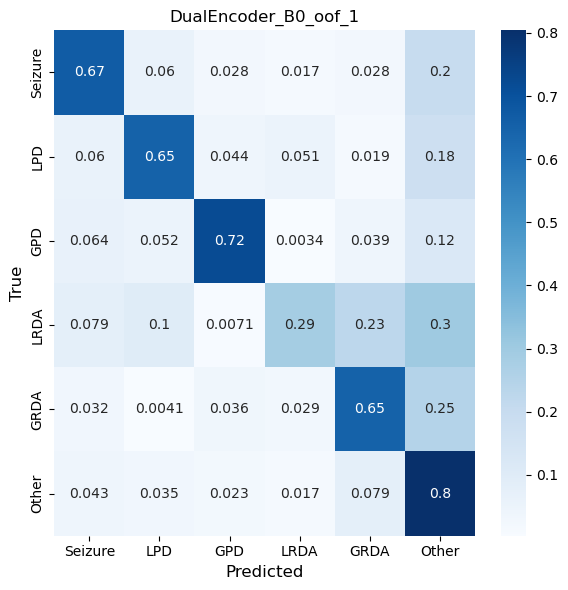

In [10]:
csv_path = f'./outputs/DualEncoder_B0_resplit/{ModelConfig.MODEL_NAME}_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

In [ ]:
# check distribution of targets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
train_all["target"].value_counts().plot(kind="bar", ax=axes[0])
train_hard["target"].value_counts().plot(kind="bar", ax=axes[1])
axes[0].set_title("Easy")
axes[1].set_title("Hard")
fig.tight_layout()
plt.show()

In [ ]:
# hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

In [ ]:
# hms_predictor.train_model(train_easy, train_hard, all_specs, all_eegs)

In [ ]:


# hms_predictor = HMSPredictor(paths.OUTPUT_DIR, ModelConfig, k_fold=5)

In [ ]:
# new figure
fig, axes = plt.subplots(6, 5, figsize=(18, 16), sharex=True, sharey=True)

plot_oof = oof_df[oof_df['kl_loss'] > 0.2]

for row in range(axes.shape[0]):
    row_selects = plot_oof[plot_oof['target_id']==row]
    target_label = BRAIN_ACTIVITY[row]
    for col in range(axes.shape[1]):
        ax = axes[row, col]
        idx = np.random.choice(row_selects.index)
        df_rows = plot_oof.loc[idx]
        ax.plot(df_rows[TARGETS].values , label='True')
        ax.plot(df_rows[TARGETS_PRED].values, label='Pred')
        ax.set_title(f"{idx} | KL: {df_rows['kl_loss']:.4f} ") #
        ax.set_xticks(range(6))
        ax.set_xticklabels(BRAIN_ACTIVITY)
        ax.grid(True)
        ax.legend()
        if col == 0:
            ax.set_ylabel(target_label, fontsize=12)
       
fig.tight_layout()
plt.show()


